# Zillow Home Price Prediction using Time Series Analysis

* Student: Graham Wilson
* Instructor: Rafael
* Cohort: DS041320

## Overview

A Real Estate investment firm is interested in entering the Fort Worth housing market. They've requested information on the most profitable five zip codes in terms of a forward looking 3 year return on investment (ROI).

The provided data is from Zillow's research page: https://www.zillow.com/research/data/. The data can also be found in the repository as a csv file: 'zillow_data.csv'. This dataset contains monthly home prices from 1996 through 2018 for much of the United States.

This analysis aims to use the Time Series modeling technique known as SARIMA(Seasonal Auto-regressive Inegrated Moving Average) to accurately predict and forecast ROI for the target area. 

# Load the Data/Filtering for Chosen Zipcodes

In [42]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [2]:
#Import file and observe data structure
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
#Create a function for reshaping df into a time series friendly format
def melt_data(df):
    melted = pd.melt(df, id_vars=['SizeRank', 'RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
#Reshape from wide to long format for time series analysis
melted_df = melt_data(df)
melted_df.head()

,SizeRank,RegionID,RegionName,City,State,Metro,CountyName,time,value
0,1,84654,60657,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,2,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,3,91982,77494,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,4,84616,60614,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,5,93144,79936,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [5]:
#Create a df with zipcodes that only apply to the Fort Worth/Tarrant County
fw_df = melted_df[melted_df['CountyName']=='Tarrant']
fw_df.tail(2)

,SizeRank,RegionID,RegionName,City,State,Metro,CountyName,time,value
3896211,9340,91219,76060,Kennedale,TX,Dallas-Fort Worth,Tarrant,2018-04-01,243200.0
3900184,13313,91179,76005,Arlington,TX,Dallas-Fort Worth,Tarrant,2018-04-01,373900.0


In [6]:
#Drop columns
fw_df = fw_df.drop(["RegionID", "City", "State", "Metro", "CountyName", "SizeRank"], axis=1)

In [7]:
# Rename RegionName column more appropriately to Zipcode
fw_df.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
fw_df.head()

,Zipcode,time,value
153,76063,1996-04-01,148100.0
170,76244,1996-04-01,139800.0
335,76116,1996-04-01,85800.0
550,76179,1996-04-01,107100.0
562,76137,1996-04-01,117500.0


In [8]:
fw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15635 entries, 153 to 3900184
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Zipcode  15635 non-null  int64         
 1   time     15635 non-null  datetime64[ns]
 2   value    15635 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 488.6 KB


# Data Preprocessing and Exploration

In [9]:
#change df index to datetime format
fw_df.set_index('time', inplace=True)

In [18]:
fw_df.tail()

,Zipcode,value
time,,
2018-04-01,76103,126300.0
2018-04-01,76054,275500.0
2018-04-01,76164,103600.0
2018-04-01,76060,243200.0
2018-04-01,76005,373900.0


## Plot

In [121]:


#fw_zips = fw_df['Zipcode'].unique()


# For-loop to plot data for each zip code
#plt.figure()
#for zip_code in fw_zips:
#    X = fw_df.index
#    y = fw_df.loc[fw_df['Zipcode'] == zip_code, ['value']]
#    plt.plot(X, y)
#plt.show()

## Check for Stationarity

* Time series modeling for accurate forecasting requires the data to be stationary. This is achieved when the statistical properties of mean, variance, and covariance remain constant over time. Stationarity can be tested in a variety of ways, however in this case the Dickey-Fuller test will be used. The null hypothesis for this test assumes that the provided data are not stationary. To reject the null hypothesis and confirm that the data are stationary, the test statistics  must be less than the critical value of p < 0.05. 

In [25]:
#Generate a for loop isolate each individual zip codes home values over time
zip_dfs = [] #Create an empty list to store each individual zip code df
zip_list = fw_df['Zipcode'].unique() #Make a list of each unique  zipcode
for zc in zip_list:
    zip_dfs.append(pd.DataFrame(fw_df[fw_df['Zipcode']==zc][['value']].copy()))

zip_dfs

[               value
 time                
 1996-04-01  148100.0
 1996-05-01  148000.0
 1996-06-01  147800.0
 1996-07-01  147700.0
 1996-08-01  147500.0
 ...              ...
 2017-12-01  261100.0
 2018-01-01  262200.0
 2018-02-01  264100.0
 2018-03-01  266500.0
 2018-04-01  267800.0
 
 [265 rows x 1 columns],                value
 time                
 1996-04-01  139800.0
 1996-05-01  140100.0
 1996-06-01  140700.0
 1996-07-01  141500.0
 1996-08-01  142300.0
 ...              ...
 2017-12-01  249700.0
 2018-01-01  250300.0
 2018-02-01  251000.0
 2018-03-01  251400.0
 2018-04-01  251300.0
 
 [265 rows x 1 columns],                value
 time                
 1996-04-01   85800.0
 1996-05-01   86100.0
 1996-06-01   86500.0
 1996-07-01   87000.0
 1996-08-01   87500.0
 ...              ...
 2017-12-01  181900.0
 2018-01-01  183300.0
 2018-02-01  185000.0
 2018-03-01  186600.0
 2018-04-01  187800.0
 
 [265 rows x 1 columns],                value
 time                
 1996-04-01  107100.

In [28]:
#Loop through the indiviual zip codes and calculate dickey-fuller test stats for a stationarity check
for zc in zip_list:
    df_zc = fw_df.loc[fw_df['Zipcode'] == zc]
    dftest = adfuller(df_zc['value']) 
        
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value',
                                            '#Lags Used', '#Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
        
    print(f'Dickey-Fuller Results: {zc} \n')
    print(dfoutput)
    print('\n')

Dickey-Fuller Results: 76063 

Test Statistics           0.815053
p-value                   0.991875
#Lags Used               13.000000
#Observations Used      251.000000
Critical Value (1%)      -3.456674
Critical Value (5%)      -2.873125
Critical Value (10%)     -2.572944
dtype: float64


Dickey-Fuller Results: 76244 

Test Statistics          -0.885362
p-value                   0.792755
#Lags Used               16.000000
#Observations Used      248.000000
Critical Value (1%)      -3.456996
Critical Value (5%)      -2.873266
Critical Value (10%)     -2.573019
dtype: float64


Dickey-Fuller Results: 76116 

Test Statistics           0.583462
p-value                   0.987201
#Lags Used               14.000000
#Observations Used      250.000000
Critical Value (1%)      -3.456781
Critical Value (5%)      -2.873172
Critical Value (10%)     -2.572969
dtype: float64


Dickey-Fuller Results: 76179 

Test Statistics           0.057925
p-value                   0.963068
#Lags Used          


Test Statistics           2.410135
p-value                   0.999015
#Lags Used               14.000000
#Observations Used      250.000000
Critical Value (1%)      -3.456781
Critical Value (5%)      -2.873172
Critical Value (10%)     -2.572969
dtype: float64


Dickey-Fuller Results: 76011 

Test Statistics          -1.159927
p-value                   0.690592
#Lags Used               13.000000
#Observations Used      251.000000
Critical Value (1%)      -3.456674
Critical Value (5%)      -2.873125
Critical Value (10%)     -2.572944
dtype: float64


Dickey-Fuller Results: 76123 

Test Statistics          -0.776898
p-value                   0.825814
#Lags Used                6.000000
#Observations Used      258.000000
Critical Value (1%)      -3.455953
Critical Value (5%)      -2.872809
Critical Value (10%)     -2.572775
dtype: float64


Dickey-Fuller Results: 76140 

Test Statistics          -1.644956
p-value                   0.459672
#Lags Used               14.000000
#Observations U

* None of the p-values for any of the zip codes fall below the critical value, so the null hypothesis holds up and none of the data are stationary.  

## Decomposition

* Time series decomposition splits the time series data into three different components: seasonal, trend, and residuals. This makes it easy to visualize whether or not time series data are stationary and ready to model. Having already performed the dickey-fuller test, it is assumed at this will return what is already known - that the series is not stationary. However, these visualizations will help isolate trends and seasonality in a visual format. 

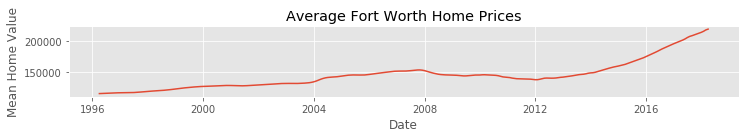

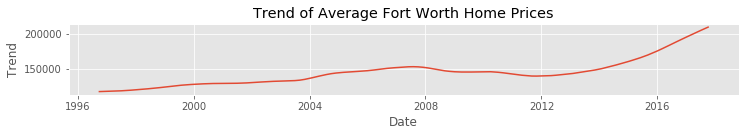

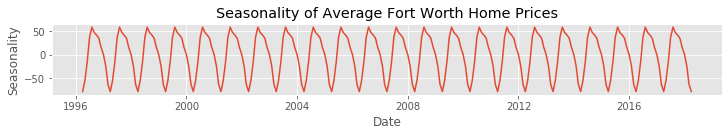

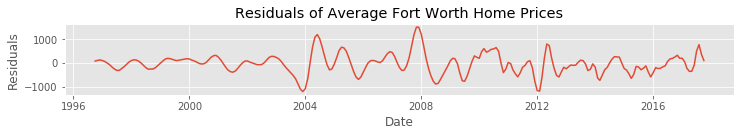

In [40]:
df_mean = fw_df.groupby('time').mean()
df_mean.drop(['Zipcode'], axis=1, inplace=True)

decomp = seasonal_decompose(df_mean, model='additive')

trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid



plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(df_mean)
plt.xlabel('Date')
plt.ylabel('Mean Home Value')
plt.title('Average Fort Worth Home Prices')

plt.figure(figsize=(12, 6))
plt.subplot(412)
plt.plot(trend)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.title('Trend of Average Fort Worth Home Prices')

plt.figure(figsize=(12, 6))
plt.subplot(413)
plt.plot(seasonal)
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.title('Seasonality of Average Fort Worth Home Prices')


plt.figure(figsize=(12, 6))
plt.subplot(414)
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Average Fort Worth Home Prices');

* From the above charts, it's clear that there is an overall upward trend in home prices over time, along with what looks like yearly seasonality.

## ACF and PACF

* A general assumption for time series modeling is that tomorrow's home value will be related to today's (or yesterday's) price. Both auto correlation (ACF), and partial auto correlation (PACF) are two tools that help with exactly how correlative current prices are to previous prices. ACF correlates the influence of previous price based over a given lag time, whereas PACF removes indirect correlation and measures direct influence of price between two specific observations. 



* Visualizing both of these measurements help with determining the range in hyper-parameter (p, q) selection for optimal time series modeling. With p coming from the PACF graph, and q from the ACF graph. 

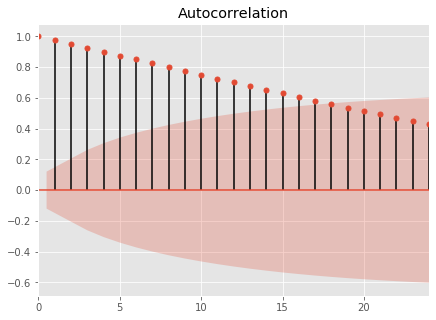

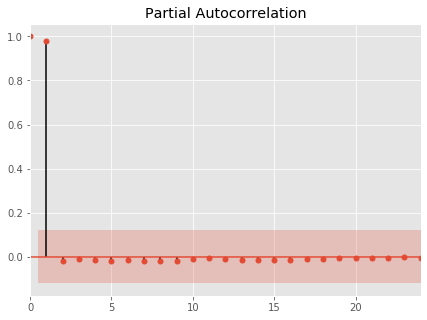

In [43]:
rcParams['figure.figsize']=7,5
plot_acf(df_mean); plt.xlim(0,24);
plot_pacf(df_mean); plt.xlim(0,24);

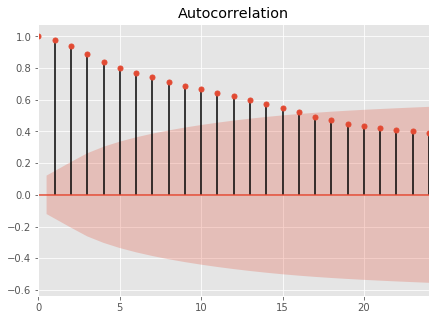

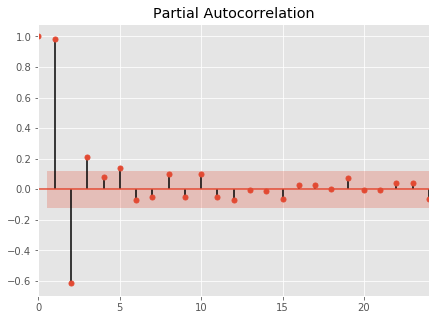

In [124]:
rcParams['figure.figsize']=7,5
plot_acf(df_mean.diff(periods=4).dropna()); plt.xlim(0,24);
plot_pacf(df_mean.diff(periods=4).dropna()); plt.xlim(0,24);

* Plotting the mean ACF for the Fort Worth Area shows a significant correlation to the previous time period with significant lags somewhere between 0 and 15. This is represented at q and seasonal Q within the model



* The  initial PACF showed no significance. However, by subtracting 4 months from its current value, the PACF begins to reveal that PACF (p and Seasonal P) should play a role in selecting higher orders for this specific hyper-parameter. Ideally, somewhere between 0 and 6.


* Ideally, this would be done for each individual zip code as each one follows its own trend, and would result in differing p and q values. 

# Model

* As observed from the decomposition graphs, the data needs to be adjusted for both seasonality and positive trends over time. This requires the use of the SARIMA approach to time series modeling, where seasonality must also be taken into account. 



* The orders of hyper-parameters needed to fully complete an accurate prediction for each individual zip code require a high level of computational time and power. This was observed in many trial runs of a single zip code within the 'starter_notebook' located in this repository. Due to a time constraint, the hyper-parameter settings have been scaled down in hopes that lower orders will result in meaningful predictions across enough zip codes to provide accurate forecasts. 

In [56]:
# Select desired hyper-parameters for SARIMA modeling
p = range(0, 3)
d = range(1, 3)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [57]:
#Build model and loop through all zip codes to generate optimal modeling parameters
#ans = []

#for df, name in zip(zip_dfs, zip_list):
#    for comb in pdq:
#        for combs in pdqs:
#           try:
#                mod = sm.tsa.statespace.SARIMAX(df,
#                                           order=comb,
#                                           seasonal_order=combs,
#                                           enforce_stationarity=False,
#                                           enforce_invertibility=False)
#
#               output = mod.fit()
#               ans.append([name, comb, combs, output.aic])
#               print('Result for {}'.format(name) + 'ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
#           except:
#                continue

Result for 76063ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4233.383950780238
Result for 76063ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3980.5735922069634
Result for 76063ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3736.0972198419404
Result for 76063ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4308.757933298457
Result for 76063ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3969.945051859918
Result for 76063ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3714.0862199656935
Result for 76063ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3960.57566334446
Result for 76063ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3945.331385776741
Result for 76063ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3729.730068838221
Result for 76063ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3968.8411730227417
Result for 76063ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3939.6928501603056
Result for 76063ARIMA (0, 1, 0) x (1, 2, 2, 12)12 

Result for 76063ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3203.0215192582255
Result for 76063ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3534.119942020046
Result for 76063ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3440.0892879907924
Result for 76063ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3199.579832524377
Result for 76063ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3549.517722620776
Result for 76063ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3448.3852806465284
Result for 76063ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3136.5778148072473
Result for 76063ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3322.7337595602326
Result for 76063ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3324.715690640708
Result for 76063ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3241.0416112084536
Result for 76063ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3263.0467287293113
Result for 76063ARIMA (0, 2, 2) x (2, 2, 1, 12)

Result for 76063ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3467.1734256738846
Result for 76063ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3142.248892959531
Result for 76063ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3277.178402329646
Result for 76063ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3279.1673356706506
Result for 76063ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3260.835952420376
Result for 76063ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3218.356391292956
Result for 76063ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3218.637575684653
Result for 76063ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3201.1750813814847
Result for 76063ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3685.9016222487785
Result for 76063ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3427.4575851130376
Result for 76063ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3199.6999233372953
Result for 76063ARIMA (1, 2, 2) x (0, 2, 0, 12)1

Result for 76063ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3188.0653189796276
Result for 76063ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3188.280012894854
Result for 76063ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3190.277482365318
Result for 76063ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3699.9991063656707
Result for 76063ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3482.9629805409554
Result for 76063ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3209.5508574155583
Result for 76063ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3779.1857192144894
Result for 76063ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3675.759372259814
Result for 76063ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3218.5690334932624
Result for 76063ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3448.954078777583
Result for 76063ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3449.339488930814
Result for 76063ARIMA (2, 2, 1) x (1, 1, 2, 12)1

Result for 76244ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3456.97331068773
Result for 76244ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3966.2891647921683
Result for 76244ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3677.373281768531
Result for 76244ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3423.4046050663205
Result for 76244ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3677.8299412465794
Result for 76244ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3659.4730497811197
Result for 76244ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3389.466475108051
Result for 76244ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3669.4629210212333
Result for 76244ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3641.1638295387074
Result for 76244ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3402.7206703581564
Result for 76244ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3465.0550871011355
Result for 76244ARIMA (0, 2, 0) x (2, 1, 1, 12)

Result for 76244ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3533.211001001575
Result for 76244ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3261.7548361203008
Result for 76244ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3633.016815933596
Result for 76244ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3511.5566459636602
Result for 76244ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3279.1841431384028
Result for 76244ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3377.1893484743673
Result for 76244ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3361.777254773631
Result for 76244ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3309.3270100667833
Result for 76244ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3326.725872310012
Result for 76244ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3302.3802309061994
Result for 76244ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3275.5242412472767
Result for 76244ARIMA (1, 2, 0) x (0, 1, 0, 12)

Result for 76244ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3365.224566499272
Result for 76244ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3285.6361893082453
Result for 76244ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3310.4842981567444
Result for 76244ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3300.859345828996
Result for 76244ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3258.9073397440507
Result for 76244ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3249.7193096006476
Result for 76244ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3754.9782135695687
Result for 76244ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3505.7342956192924
Result for 76244ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3261.2300135980113
Result for 76244ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3813.757921202336
Result for 76244ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3550.2026455527794
Result for 76244ARIMA (2, 1, 2) x (0, 2, 2, 12

Result for 76116ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3561.1301086884437
Result for 76116ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3932.0977279442977
Result for 76116ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3604.6573411603767
Result for 76116ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3412.5896084391716
Result for 76116ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4002.0525392239138
Result for 76116ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3675.2232799153735
Result for 76116ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3338.2964323691895
Result for 76116ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3708.3649507883074
Result for 76116ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3605.2114612012383
Result for 76116ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3413.917050638122
Result for 76116ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3728.4045050901423
Result for 76116ARIMA (0, 1, 1) x (1, 2, 1, 

Result for 76116ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3635.195110807651
Result for 76116ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3344.570538209354
Result for 76116ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3515.3071753025365
Result for 76116ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3510.7932906635406
Result for 76116ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3284.1086435382354
Result for 76116ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3546.8426161134767
Result for 76116ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3532.6895896001774
Result for 76116ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3303.259336506162
Result for 76116ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3313.5038579249735
Result for 76116ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3313.9380353205197
Result for 76116ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3284.4784773376387
Result for 76116ARIMA (1, 1, 0) x (2, 2, 0, 12

Result for 76116ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3520.70135191863
Result for 76116ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3464.979360390609
Result for 76116ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3139.527649401019
Result for 76116ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3269.271732767731
Result for 76116ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3268.8493542846236
Result for 76116ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3239.1849003525012
Result for 76116ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3258.5203712194016
Result for 76116ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3255.1783934654577
Result for 76116ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3215.985727928324
Result for 76116ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3746.870601102116
Result for 76116ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3529.532655425337
Result for 76116ARIMA (2, 1, 0) x (0, 1, 2, 12)12 :

Result for 76116ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3259.8849889806997
Result for 76116ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3229.3721515323577
Result for 76116ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3227.229325037171
Result for 76116ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3289.122030613036
Result for 76116ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3725.452604894125
Result for 76116ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3403.7554441820057
Result for 76116ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3195.247845329255
Result for 76116ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3795.5633436716325
Result for 76116ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3563.814361268999
Result for 76116ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3177.217053235213
Result for 76116ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3458.7670029144683
Result for 76116ARIMA (2, 2, 2) x (1, 1, 1, 12)12

Result for 76179ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3275.935451284872
Result for 76179ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3089.857611412688
Result for 76179ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3680.4189618917253
Result for 76179ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3407.1951522970076
Result for 76179ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3063.204351324922
Result for 76179ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3389.1863121458446
Result for 76179ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3337.2704131997307
Result for 76179ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3089.4276307975433
Result for 76179ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3397.2900628730035
Result for 76179ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3338.9429708382595
Result for 76179ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3008.7931473581784
Result for 76179ARIMA (0, 2, 1) x (2, 1, 0, 12

Result for 76179ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3361.6802736425734
Result for 76179ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3362.4444206023736
Result for 76179ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3190.339912773735
Result for 76179ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3367.425874589222
Result for 76179ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3360.1607395201027
Result for 76179ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3111.636453236768
Result for 76179ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3180.6505074701654
Result for 76179ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3182.0265463292008
Result for 76179ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3182.6745658202262
Result for 76179ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3154.2441409483754
Result for 76179ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3154.3305010201448
Result for 76179ARIMA (1, 2, 0) x (2, 2, 2, 12

Result for 76179ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3115.962907553311
Result for 76179ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3166.569017948791
Result for 76179ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3098.9329336727833
Result for 76179ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3121.8997084783705
Result for 76179ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3121.7422775979
Result for 76179ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3123.003936075792
Result for 76179ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3036.069293189566
Result for 76179ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3577.333530018488
Result for 76179ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3358.5412630106707
Result for 76179ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3120.081122348238
Result for 76179ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3668.991429352872
Result for 76179ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : A

Result for 76137ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3356.700952176009
Result for 76137ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3306.3334011546212
Result for 76137ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3658.7161705596136
Result for 76137ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3408.886545785493
Result for 76137ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3230.4438388205717
Result for 76137ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3732.07124195541
Result for 76137ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3435.9212272167206
Result for 76137ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3163.119442148475
Result for 76137ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3495.8919375332353
Result for 76137ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3410.0886476292976
Result for 76137ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3232.482783485898
Result for 76137ARIMA (0, 1, 2) x (1, 2, 0, 12)12

Result for 76137ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3661.41942876505
Result for 76137ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3381.127980254571
Result for 76137ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3088.4403074826664
Result for 76137ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3383.6681014844457
Result for 76137ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3356.4357660822707
Result for 76137ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3133.23806627058
Result for 76137ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3364.862413982446
Result for 76137ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3329.1279998202
Result for 76137ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3041.5775648159165
Result for 76137ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3197.9658697439354
Result for 76137ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3147.7075811946634
Result for 76137ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : 

Result for 76137ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3205.5371461974
Result for 76137ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3330.4362858057684
Result for 76137ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3328.746427445276
Result for 76137ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3161.9152562318113
Result for 76137ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3188.6168826304797
Result for 76137ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3190.3636596755364
Result for 76137ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3192.25080784855
Result for 76137ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3144.8798569615474
Result for 76137ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3141.9388798021328
Result for 76137ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3062.3447334858847
Result for 76137ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3570.259093705975
Result for 76137ARIMA (2, 1, 1) x (0, 1, 1, 12)12 

Result for 76137ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3174.409485496055
Result for 76137ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3129.569480613276
Result for 76137ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3136.372095269964
Result for 76137ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3126.657781454058
Result for 76137ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3084.4642047540174
Result for 76051ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4268.886358751732
Result for 76051ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4043.931448694132
Result for 76051ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3839.8092319622483
Result for 76051ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4301.841674593977
Result for 76051ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3967.2819918211208
Result for 76051ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3713.2843276677204
Result for 76051ARIMA (0, 1, 0) x (1, 1, 0, 12)12 

Result for 76051ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3895.3410979574855
Result for 76051ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3656.3312781974546
Result for 76051ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3428.6925783540933
Result for 76051ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3908.9100133799993
Result for 76051ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3665.6225972562024
Result for 76051ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3401.6373370211077
Result for 76051ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3742.57361815367
Result for 76051ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3653.225470482024
Result for 76051ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3430.328898360447
Result for 76051ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3706.5148607197934
Result for 76051ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3623.615488047706
Result for 76051ARIMA (0, 2, 2) x (1, 2, 2, 12)1

Result for 76051ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3418.3648310693698
Result for 76051ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3728.97232336014
Result for 76051ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3703.6683528219064
Result for 76051ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3460.054508930695
Result for 76051ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3672.2021595492424
Result for 76051ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3647.341023134587
Result for 76051ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3434.620459189512
Result for 76051ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3515.495375682777
Result for 76051ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3511.4813303077594
Result for 76051ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3461.197470450934
Result for 76051ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3457.889960738333
Result for 76051ARIMA (1, 2, 1) x (2, 2, 1, 12)12 :

Result for 76051ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3610.0763643671035
Result for 76051ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3439.033799050295
Result for 76051ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3448.0966886608735
Result for 76051ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3449.461899508538
Result for 76051ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3451.2284098544123
Result for 76051ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3382.1933607248657
Result for 76051ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3382.6397458229603
Result for 76051ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3383.1776688753
Result for 76051ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3868.8385999302836
Result for 76051ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3661.4674349289457
Result for 76051ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3413.75833121739
Result for 76051ARIMA (2, 2, 1) x (0, 2, 0, 12)12 

Result for 76133ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3189.712959376093
Result for 76133ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3159.5283263743036
Result for 76133ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3102.6293791485537
Result for 76133ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3564.9112456630146
Result for 76133ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3323.023938025536
Result for 76133ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3103.469677852061
Result for 76133ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3649.587230193991
Result for 76133ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3352.494209404894
Result for 76133ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3115.9076668871667
Result for 76133ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3349.0703709308864
Result for 76133ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3323.659524261495
Result for 76133ARIMA (0, 2, 0) x (1, 1, 2, 12)12

Result for 76133ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3046.635950371049
Result for 76133ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3600.165803221603
Result for 76133ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3299.858518011559
Result for 76133ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =2982.565020979874
Result for 76133ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3322.005125739428
Result for 76133ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3272.2866953019893
Result for 76133ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3048.193566444886
Result for 76133ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3328.8145909689033
Result for 76133ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3270.8663031296774
Result for 76133ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =2963.825124307843
Result for 76133ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3141.2978047426964
Result for 76133ARIMA (1, 1, 2) x (2, 1, 1, 12)12 

Result for 76133ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3291.1739724689683
Result for 76133ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3063.4967593948427
Result for 76133ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3301.9627362401966
Result for 76133ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3287.850842575578
Result for 76133ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =2973.6668577389873
Result for 76133ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3111.9983422290206
Result for 76133ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3062.817065597725
Result for 76133ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3066.0407349307616
Result for 76133ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3074.86834333318
Result for 76133ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3071.6579924818807
Result for 76133ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3066.962924201949
Result for 76133ARIMA (2, 1, 2) x (0, 1, 0, 12)1

Result for 76010ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3552.9104800780633
Result for 76010ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3540.438726063977
Result for 76010ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3408.0499980132427
Result for 76010ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3406.291347143472
Result for 76010ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3392.0409542992056
Result for 76010ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3692.4821796678552
Result for 76010ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3455.9877726781433
Result for 76010ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3292.444412479742
Result for 76010ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3752.3915240670153
Result for 76010ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3427.6775086824828
Result for 76010ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3160.4328610307048
Result for 76010ARIMA (0, 1, 1) x (1, 1, 0, 12

Result for 76010ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3370.411902170078
Result for 76010ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3169.0901228766606
Result for 76010ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3704.4265437960985
Result for 76010ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3391.917144734658
Result for 76010ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3148.391648593294
Result for 76010ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3391.3295041347737
Result for 76010ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3371.889644974097
Result for 76010ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3167.9152128577052
Result for 76010ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3402.58127929161
Result for 76010ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3357.092904112327
Result for 76010ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3147.2412124533653
Result for 76010ARIMA (1, 1, 0) x (2, 1, 0, 12)12 

Result for 76010ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3338.6086156082765
Result for 76010ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3301.7733621551074
Result for 76010ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3069.9851135496265
Result for 76010ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3357.901784736236
Result for 76010ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3292.2645522047533
Result for 76010ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3029.4961580738927
Result for 76010ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3147.504873092643
Result for 76010ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3109.072929607968
Result for 76010ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3071.925705842252
Result for 76010ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3114.270977375666
Result for 76010ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3098.107362785057
Result for 76010ARIMA (1, 2, 2) x (2, 2, 2, 12)12

Result for 76010ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3075.99607063896
Result for 76010ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3135.068385095252
Result for 76010ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3134.728220662565
Result for 76010ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3089.0291025557262
Result for 76010ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3111.227323490022
Result for 76010ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3085.398916373661
Result for 76010ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3098.4764480428366
Result for 76010ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3536.3708987415557
Result for 76010ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3230.245144773903
Result for 76010ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3068.313205477267
Result for 76010ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3618.854652134597
Result for 76010ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : 

Result for 76112ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3126.327669196815
Result for 76112ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3109.4330848419177
Result for 76112ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3506.6866208880133
Result for 76112ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3232.806436976867
Result for 76112ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3075.199564931843
Result for 76112ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3588.5940745877806
Result for 76112ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3274.3273409890076
Result for 76112ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =2977.6909244907215
Result for 76112ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3329.1451290725727
Result for 76112ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3286.971449653526
Result for 76112ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3077.1821062133085
Result for 76112ARIMA (0, 2, 1) x (1, 2, 0, 12)

Result for 76112ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3313.6494693126233
Result for 76112ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3069.7208642309033
Result for 76112ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3320.3992488146323
Result for 76112ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3291.4951458034066
Result for 76112ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3109.185605295887
Result for 76112ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3320.2195243024275
Result for 76112ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3281.108983213857
Result for 76112ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3037.323112070856
Result for 76112ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3148.928145600947
Result for 76112ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3146.267221223115
Result for 76112ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3111.000004957955
Result for 76112ARIMA (1, 2, 0) x (2, 2, 0, 12)12

Result for 76112ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3281.056099306579
Result for 76112ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3241.37658281077
Result for 76112ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =2984.131031407812
Result for 76112ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3119.0340254945913
Result for 76112ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3099.3723797741177
Result for 76112ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3085.195744690198
Result for 76112ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3078.382664623442
Result for 76112ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3068.929988558905
Result for 76112ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3041.345418762155
Result for 76112ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3486.971268858826
Result for 76112ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3262.454207308564
Result for 76112ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : A

Result for 76017ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3340.885503724906
Result for 76017ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3304.3164860166526
Result for 76017ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3307.270607069903
Result for 76017ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3344.984197170974
Result for 76017ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3572.906124112008
Result for 76017ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3335.162222938967
Result for 76017ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3167.5975629474456
Result for 76017ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3643.882271979045
Result for 76017ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3399.8684750781795
Result for 76017ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3085.7633739859957
Result for 76017ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3417.508600440758
Result for 76017ARIMA (0, 1, 2) x (1, 1, 1, 12)12 

Result for 76017ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3259.0211662858246
Result for 76017ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3090.1344846854417
Result for 76017ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3624.7353679256494
Result for 76017ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3335.4501682191567
Result for 76017ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3028.2887821244967
Result for 76017ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3354.2453427113423
Result for 76017ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3316.4236881768275
Result for 76017ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3092.1322097819902
Result for 76017ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3361.076156085447
Result for 76017ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3308.2627969907962
Result for 76017ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3007.8828545647084
Result for 76017ARIMA (1, 1, 1) x (2, 1, 0, 

Result for 76017ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3314.855649633607
Result for 76017ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3313.013694062536
Result for 76017ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3164.010349164685
Result for 76017ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3311.168271995998
Result for 76017ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3300.7895142725447
Result for 76017ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3085.499261746477
Result for 76017ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3137.827556709236
Result for 76017ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3139.480410770957
Result for 76017ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3141.0578020883913
Result for 76017ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3091.399656121156
Result for 76017ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3089.4768147374753
Result for 76017ARIMA (2, 1, 0) x (2, 2, 2, 12)12 :

Result for 76017ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =2984.9498562962353
Result for 76017ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3118.1515048372275
Result for 76017ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3119.0545576222844
Result for 76017ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3071.471730484243
Result for 76017ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3079.0769793790587
Result for 76017ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3076.7661007228608
Result for 76017ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3060.7077058832447
Result for 76039ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4173.736691622752
Result for 76039ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3943.5366644106844
Result for 76039ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3738.051202245485
Result for 76039ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4231.789805311843
Result for 76039ARIMA (0, 1, 0) x (0, 2, 1, 12)

Result for 76039ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3429.319650125084
Result for 76039ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3354.0073526444794
Result for 76039ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3799.481120332905
Result for 76039ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3535.559882827671
Result for 76039ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3308.561863175866
Result for 76039ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3857.2768548817285
Result for 76039ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3586.758703656081
Result for 76039ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3297.4425182610453
Result for 76039ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3662.3456960581525
Result for 76039ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3512.7610766918588
Result for 76039ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3310.515439966302
Result for 76039ARIMA (0, 2, 2) x (1, 2, 0, 12)12

Result for 76039ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3882.9072292784776
Result for 76039ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3669.9188769379502
Result for 76039ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3315.6449503584354
Result for 76039ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3640.274255708101
Result for 76039ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3515.8569359837256
Result for 76039ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3329.9237695728234
Result for 76039ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3619.2680570913126
Result for 76039ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3589.7949140266646
Result for 76039ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3256.9861242618363
Result for 76039ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3426.446043290425
Result for 76039ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3428.052672545862
Result for 76039ARIMA (1, 2, 1) x (2, 1, 2, 12

Result for 76039ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3299.6617626964835
Result for 76039ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3538.713255522707
Result for 76039ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3536.3209958907264
Result for 76039ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3310.661313471144
Result for 76039ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3354.522034151162
Result for 76039ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3355.950704005334
Result for 76039ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3356.5399342724068
Result for 76039ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3312.980949890907
Result for 76039ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3313.228953741352
Result for 76039ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3314.583513265704
Result for 76039ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3777.963204705322
Result for 76039ARIMA (2, 2, 1) x (0, 1, 1, 12)12 :

Result for 76108ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3288.13393497601
Result for 76108ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3236.924508580196
Result for 76108ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3287.4262039424257
Result for 76108ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3259.011363527134
Result for 76108ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3189.403803356653
Result for 76108ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3661.747737653853
Result for 76108ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3434.5457175344277
Result for 76108ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3216.0525771003313
Result for 76108ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3737.291334746403
Result for 76108ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3441.9672715862534
Result for 76108ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3222.665714202997
Result for 76108ARIMA (0, 2, 0) x (1, 1, 0, 12)12 :

Result for 76108ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3322.1023464631917
Result for 76108ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3148.661763002471
Result for 76108ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3689.676600016661
Result for 76108ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3398.3320331812174
Result for 76108ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3092.2996309005694
Result for 76108ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3434.3677908741465
Result for 76108ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3383.5073724225877
Result for 76108ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3150.073482850682
Result for 76108ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3432.477616787332
Result for 76108ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3378.077868026722
Result for 76108ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3063.9665908367965
Result for 76108ARIMA (1, 1, 2) x (2, 1, 0, 12)1

Result for 76108ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3408.446472220401
Result for 76108ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3406.1725665958047
Result for 76108ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3169.3285028915748
Result for 76108ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3404.000952342619
Result for 76108ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3397.1595073937942
Result for 76108ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3079.896189418213
Result for 76108ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3220.6959768568186
Result for 76108ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3220.886457663226
Result for 76108ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3171.2924652526044
Result for 76108ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3176.9150861778476
Result for 76108ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3172.5458415200596
Result for 76108ARIMA (2, 1, 1) x (2, 2, 2, 12)

Result for 76021ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3597.46021870511
Result for 76021ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3679.547784809776
Result for 76021ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3681.5869799203037
Result for 76021ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3666.761795772615
Result for 76021ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3575.0248207022005
Result for 76021ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3572.264969215754
Result for 76021ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3560.9993479817367
Result for 76021ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3950.9653341255453
Result for 76021ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3605.3471312692636
Result for 76021ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3419.679262061377
Result for 76021ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3986.3722727706054
Result for 76021ARIMA (0, 1, 1) x (0, 2, 1, 12)12

Result for 76021ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3260.883199707128
Result for 76021ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3223.4090861026502
Result for 76021ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3771.0311003194206
Result for 76021ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3545.197093252874
Result for 76021ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3285.848330228956
Result for 76021ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3867.216993325406
Result for 76021ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3600.9960503317075
Result for 76021ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3319.322673115692
Result for 76021ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3506.890110645604
Result for 76021ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3505.7816130928704
Result for 76021ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3320.239516344692
Result for 76021ARIMA (1, 1, 0) x (1, 2, 0, 12)12 

Result for 76021ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3786.411126583573
Result for 76021ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3507.1112357984
Result for 76021ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3172.9359756226677
Result for 76021ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3465.0119169661757
Result for 76021ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3349.783441982019
Result for 76021ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3169.9552193667287
Result for 76021ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3504.2091669758374
Result for 76021ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3448.8452979105696
Result for 76021ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3100.4542942773496
Result for 76021ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3258.001433086216
Result for 76021ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3260.3552492921544
Result for 76021ARIMA (1, 2, 2) x (2, 1, 2, 12)12

Result for 76021ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3180.2670823300696
Result for 76021ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3442.743197927506
Result for 76021ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3437.5181609402493
Result for 76021ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3207.028714959177
Result for 76021ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3207.5645283115855
Result for 76021ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3209.3319657339234
Result for 76021ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3208.928432821533
Result for 76021ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3160.1457933213387
Result for 76021ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3161.5996472002253
Result for 76021ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3159.082858361745
Result for 76021ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3671.8686674657924
Result for 76021ARIMA (2, 2, 2) x (0, 1, 1, 12)

Result for 76107ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3590.8911823908834
Result for 76107ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3577.9370525944314
Result for 76107ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3538.5353133376966
Result for 76107ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3539.2672348519595
Result for 76107ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3603.6632277547387
Result for 76107ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3995.53834923101
Result for 76107ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3690.433298494636
Result for 76107ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3426.71445009224
Result for 76107ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4053.975638316282
Result for 76107ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3756.7139698192514
Result for 76107ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3441.2696071735554
Result for 76107ARIMA (0, 2, 1) x (1, 1, 0, 12)12

Result for 76107ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3781.0633673296593
Result for 76107ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3531.5770195576965
Result for 76107ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4088.576220823614
Result for 76107ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3778.4500725791877
Result for 76107ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3541.745832692724
Result for 76107ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3746.7447747238957
Result for 76107ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3747.187026041283
Result for 76107ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3457.7040128463022
Result for 76107ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3737.6063694350364
Result for 76107ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3730.6062611014986
Result for 76107ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3511.398833214019
Result for 76107ARIMA (1, 2, 0) x (2, 1, 0, 12)

Result for 76107ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3706.845470793849
Result for 76107ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3669.408086741895
Result for 76107ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3388.598924787181
Result for 76107ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3687.542813308628
Result for 76107ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3656.4165687015775
Result for 76107ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3444.3440630316372
Result for 76107ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3486.7869394265836
Result for 76107ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3464.6355376540187
Result for 76107ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3448.201753315697
Result for 76107ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3441.747397303259
Result for 76107ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3475.815216357546
Result for 76107ARIMA (2, 1, 2) x (2, 2, 2, 12)12 

Result for 76119ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3278.797636941736
Result for 76119ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3446.2858488302204
Result for 76119ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3425.2763717189537
Result for 76119ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3393.631483543756
Result for 76119ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3395.750052051794
Result for 76119ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3365.0638106677416
Result for 76119ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3280.2916650459933
Result for 76119ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3749.065982645801
Result for 76119ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3473.106305711758
Result for 76119ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3292.238039744506
Result for 76119ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3821.9854137236166
Result for 76119ARIMA (0, 1, 2) x (0, 2, 1, 12)12

Result for 76119ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3361.1824723980108
Result for 76119ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3316.6241301609407
Result for 76119ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3789.474152190707
Result for 76119ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3485.4397933187265
Result for 76119ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3311.676687912564
Result for 76119ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3864.869717454831
Result for 76119ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3510.8050930790814
Result for 76119ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3228.4173845455643
Result for 76119ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3581.489993294005
Result for 76119ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3482.1247836763278
Result for 76119ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3312.9853069818228
Result for 76119ARIMA (1, 1, 1) x (1, 2, 0, 12)

Result for 76119ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3560.7897577676217
Result for 76119ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3315.9338588149963
Result for 76119ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3563.813772475814
Result for 76119ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3537.396487495792
Result for 76119ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3364.153046354829
Result for 76119ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3545.5272624095123
Result for 76119ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3506.629747671167
Result for 76119ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3316.7353785122023
Result for 76119ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3386.026848889918
Result for 76119ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3350.2032553228646
Result for 76119ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3351.584221543486
Result for 76119ARIMA (2, 1, 0) x (2, 2, 0, 12)12

Result for 76119ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3512.985774243297
Result for 76119ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3439.99715719683
Result for 76119ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3183.7767425296433
Result for 76119ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3329.5587796599193
Result for 76119ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3283.7764792788093
Result for 76119ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3266.138816853757
Result for 76119ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3288.5777398903238
Result for 76119ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3283.5941499831106
Result for 76119ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3242.0780967845685
Result for 76180ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4046.8729853014283
Result for 76180ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3819.8441251187533
Result for 76180ARIMA (0, 1, 0) x (0, 1, 2, 12)

Result for 76180ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3184.4806917988753
Result for 76180ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3262.0664581119677
Result for 76180ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3263.3243656791524
Result for 76180ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3207.6260203174934
Result for 76180ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3655.057003251244
Result for 76180ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3351.5761346026047
Result for 76180ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3166.924674630725
Result for 76180ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3733.915409149605
Result for 76180ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3465.1064737535758
Result for 76180ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3136.782213395392
Result for 76180ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3492.3932707665817
Result for 76180ARIMA (0, 2, 2) x (1, 1, 1, 12)

Result for 76180ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3360.414524160731
Result for 76180ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3183.4650622866156
Result for 76180ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3750.782009159467
Result for 76180ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3491.0516984583196
Result for 76180ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3140.8934027990526
Result for 76180ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3460.598460609947
Result for 76180ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3351.3035276280866
Result for 76180ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3181.975770153218
Result for 76180ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3462.6261176329617
Result for 76180ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3440.0141842288576
Result for 76180ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3096.2574402755545
Result for 76180ARIMA (1, 2, 1) x (2, 1, 0, 12)

Result for 76180ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3432.374240267064
Result for 76180ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3431.9626094614073
Result for 76180ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3184.877924342078
Result for 76180ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3436.8094393167858
Result for 76180ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3429.956219688735
Result for 76180ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3180.210044674277
Result for 76180ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3230.9872372277996
Result for 76180ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3232.214886108689
Result for 76180ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3229.121485826643
Result for 76180ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3195.485115472279
Result for 76180ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3196.707814044257
Result for 76180ARIMA (2, 2, 0) x (2, 2, 2, 12)12 :

Result for 76248ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3477.6647866846715
Result for 76248ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3645.671567341288
Result for 76248ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3661.8000849287682
Result for 76248ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3606.6704854090067
Result for 76248ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3545.8647410539425
Result for 76248ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3641.290995957024
Result for 76248ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3635.9021228535858
Result for 76248ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4050.805613797339
Result for 76248ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3839.1964512437507
Result for 76248ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3614.103108936387
Result for 76248ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4111.291452636507
Result for 76248ARIMA (0, 2, 0) x (0, 2, 1, 12)1

Result for 76248ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3564.506183838654
Result for 76248ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3532.621224244552
Result for 76248ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3985.826532560636
Result for 76248ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3715.858527254103
Result for 76248ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3457.234636804869
Result for 76248ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4048.945471471973
Result for 76248ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3860.5686143017406
Result for 76248ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3480.4259545448085
Result for 76248ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3810.930081569018
Result for 76248ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3745.8700948829205
Result for 76248ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3458.9993414197547
Result for 76248ARIMA (1, 1, 2) x (1, 2, 0, 12)12 

Result for 76248ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4096.506016071045
Result for 76248ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3836.960953368243
Result for 76248ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3504.38603515443
Result for 76248ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3777.370039374679
Result for 76248ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3757.982725751352
Result for 76248ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3494.691907091249
Result for 76248ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3773.7131373937436
Result for 76248ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3851.0409054641987
Result for 76248ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3526.0931763535664
Result for 76248ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3550.839499118423
Result for 76248ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3533.699943166433
Result for 76248ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : 

Result for 76006ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3779.0306385637887
Result for 76006ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3953.055912833076
Result for 76006ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3936.7441045903406
Result for 76006ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3669.707421342599
Result for 76006ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3788.0529622826784
Result for 76006ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3789.8626144726986
Result for 76006ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3775.896464452286
Result for 76006ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3703.1598319683826
Result for 76006ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3703.0298114751868
Result for 76006ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3690.826906085843
Result for 76006ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4082.351907173096
Result for 76006ARIMA (0, 1, 1) x (0, 1, 1, 12)1

Result for 76006ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3485.910174106278
Result for 76006ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3454.5751400532463
Result for 76006ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3486.2714979493007
Result for 76006ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3487.4589657017923
Result for 76006ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3394.4797267476342
Result for 76006ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3969.5500690543868
Result for 76006ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3756.680964945476
Result for 76006ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3514.9890709875044
Result for 76006ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4037.659481001818
Result for 76006ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3842.970625361477
Result for 76006ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3513.401582978304
Result for 76006ARIMA (1, 1, 0) x (1, 1, 0, 12)1

Result for 76006ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3903.214773621661
Result for 76006ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3624.1785386412876
Result for 76006ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3360.2752543077663
Result for 76006ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3964.4353842953024
Result for 76006ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3818.7532520040786
Result for 76006ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3394.6345757878107
Result for 76006ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3702.649410943821
Result for 76006ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3658.2067715080357
Result for 76006ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3360.530597211563
Result for 76006ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3711.696724305177
Result for 76006ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3649.3702945441296
Result for 76006ARIMA (1, 2, 2) x (1, 2, 2, 12)

Result for 76006ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3411.608943846995
Result for 76006ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3624.2247772715837
Result for 76006ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3625.4138913698434
Result for 76006ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3357.2400001832525
Result for 76006ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3618.0536551632263
Result for 76006ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3618.2258749937446
Result for 76006ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3401.8894916026848
Result for 76006ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3421.094913871879
Result for 76006ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3421.8594156933605
Result for 76006ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3421.5764200221474
Result for 76006ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3374.7418567893387
Result for 76006ARIMA (2, 2, 1) x (2, 2, 1, 1

Result for 76013ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3384.0942737708547
Result for 76013ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3149.2739467594965
Result for 76013ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3234.2555534710473
Result for 76013ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3234.3085299483732
Result for 76013ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3221.4697315631547
Result for 76013ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3192.072122340347
Result for 76013ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3189.9884090167325
Result for 76013ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3183.9829859859824
Result for 76013ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3596.1866411177284
Result for 76013ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3296.005243747427
Result for 76013ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3129.3362271740034
Result for 76013ARIMA (0, 2, 1) x (0, 2, 0, 1

Result for 76013ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3164.164558183575
Result for 76013ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3151.1264757697772
Result for 76013ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3040.540990503484
Result for 76013ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3633.738806006263
Result for 76013ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3393.519647572528
Result for 76013ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3172.6666610791
Result for 76013ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3725.1476280331044
Result for 76013ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3437.2972399465098
Result for 76013ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3179.9855958693506
Result for 76013ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3382.787638826012
Result for 76013ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3382.710763903301
Result for 76013ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : 

Result for 76013ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3117.1092283274984
Result for 76013ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3652.560319497744
Result for 76013ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3369.987363119821
Result for 76013ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3080.017335552754
Result for 76013ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3354.9461631812505
Result for 76013ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3345.1401310823658
Result for 76013ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3118.7517921513595
Result for 76013ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3354.481575702801
Result for 76013ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3327.8220410191702
Result for 76013ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3078.2323958751977
Result for 76013ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3180.401367443015
Result for 76013ARIMA (2, 1, 2) x (2, 1, 1, 12)1

Result for 76132ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3964.0369346079915
Result for 76132ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3730.4438401100206
Result for 76132ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =4116.234995870749
Result for 76132ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =4061.518204789757
Result for 76132ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3850.2255219265235
Result for 76132ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3781.055867870221
Result for 76132ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3830.466584345132
Result for 76132ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3730.6916151958394
Result for 76132ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3763.9176574711505
Result for 76132ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3848.6373827756347
Result for 76132ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3809.6630938098233
Result for 76132ARIMA (0, 1, 2) x (0, 1, 0, 12)

Result for 76132ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3695.323271003604
Result for 76132ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3696.7185777506093
Result for 76132ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3698.5432532679984
Result for 76132ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3654.1258826237286
Result for 76132ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3654.84549252633
Result for 76132ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3655.8476371321954
Result for 76132ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4122.700189134639
Result for 76132ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3802.536508387107
Result for 76132ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3562.462712181178
Result for 76132ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4167.00474754054
Result for 76132ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3956.2435309743346
Result for 76132ARIMA (1, 1, 1) x (0, 2, 2, 12)12 :

Result for 76132ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3496.5476359810464
Result for 76132ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4079.32014349967
Result for 76132ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3894.2949020208357
Result for 76132ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3640.336456048002
Result for 76132ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4141.420403579736
Result for 76132ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3953.9327848866033
Result for 76132ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3646.53896729143
Result for 76132ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3820.7014942744
Result for 76132ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3820.2919131441477
Result for 76132ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3648.624458169774
Result for 76132ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3807.316101024482
Result for 76132ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AI

Result for 76132ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3873.7925143551465
Result for 76132ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3467.907404398695
Result for 76132ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3722.697270947443
Result for 76132ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3700.697509943553
Result for 76132ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3430.026610368377
Result for 76132ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3714.206466230763
Result for 76132ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3688.403495708917
Result for 76132ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3467.4640509975407
Result for 76132ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3516.9867253723487
Result for 76132ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3517.9501087414496
Result for 76132ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3465.737319864847
Result for 76132ARIMA (2, 2, 2) x (2, 2, 0, 12)12 

Result for 76131ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3448.216729241061
Result for 76131ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3389.1653335897354
Result for 76131ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3075.7359795417333
Result for 76131ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3267.8012221784347
Result for 76131ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3202.1188814296256
Result for 76131ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3169.809419324235
Result for 76131ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3236.0663473364
Result for 76131ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3225.3800493454282
Result for 76131ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3076.6228549142224
Result for 76131ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3613.1243085579117
Result for 76131ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3340.187847167
Result for 76131ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : 

Result for 76131ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3186.8585508383876
Result for 76131ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3217.765366193488
Result for 76131ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3215.255413780619
Result for 76131ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3167.6758134282936
Result for 76131ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3632.6074238080173
Result for 76131ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3348.2756387879463
Result for 76131ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3166.8418308246078
Result for 76131ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3709.617357053901
Result for 76131ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3463.530027295561
Result for 76131ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3127.464725660498
Result for 76131ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3431.529554966726
Result for 76131ARIMA (1, 2, 1) x (1, 1, 1, 12)12

Result for 76131ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3415.0517028661093
Result for 76131ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3196.1944246152207
Result for 76131ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3691.809669702211
Result for 76131ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3442.0657372424066
Result for 76131ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3195.065838882895
Result for 76131ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3403.7672005376444
Result for 76131ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3399.399653001974
Result for 76131ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3177.667808642758
Result for 76131ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3384.5921769090137
Result for 76131ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3376.6867684913036
Result for 76131ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3144.1122390166443
Result for 76131ARIMA (2, 2, 0) x (2, 1, 0, 12)

Result for 76053ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3529.317788438399
Result for 76053ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3419.213107840961
Result for 76053ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3221.488722164161
Result for 76053ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3555.0796212213572
Result for 76053ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3487.256505157899
Result for 76053ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3175.555186324197
Result for 76053ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3273.6117345441553
Result for 76053ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3270.599157793008
Result for 76053ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3238.4896040965523
Result for 76053ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3284.979650348156
Result for 76053ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3264.778916822022
Result for 76053ARIMA (0, 1, 2) x (2, 2, 2, 12)12 :

Result for 76053ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3143.373315552939
Result for 76053ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3172.055872369019
Result for 76053ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3171.470294753989
Result for 76053ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3101.7903740687225
Result for 76053ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3142.9542557881146
Result for 76053ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3140.285340922598
Result for 76053ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3099.6005027402643
Result for 76053ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3604.1164822025685
Result for 76053ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3278.634265125038
Result for 76053ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3093.819403221371
Result for 76053ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3693.39336744442
Result for 76053ARIMA (1, 1, 2) x (0, 2, 1, 12)12 :

Result for 76053ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3099.742626212016
Result for 76053ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3094.792728174756
Result for 76053ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3623.0512068891417
Result for 76053ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3299.118462782876
Result for 76053ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3106.9673602476805
Result for 76053ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3711.465222488653
Result for 76053ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3435.2994713518074
Result for 76053ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3068.7567921243267
Result for 76053ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3349.244532867719
Result for 76053ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3344.9379474953275
Result for 76053ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3101.2458521513054
Result for 76053ARIMA (2, 1, 1) x (1, 2, 0, 12)1

Result for 76182ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4225.944318417542
Result for 76182ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3857.4863315099165
Result for 76182ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3639.0146965372614
Result for 76182ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3923.058965825473
Result for 76182ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3909.4649035871525
Result for 76182ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3709.935109707604
Result for 76182ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3893.268151871647
Result for 76182ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3873.1419116956167
Result for 76182ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3631.4607411826355
Result for 76182ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3725.550222785594
Result for 76182ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3727.5092193597425
Result for 76182ARIMA (0, 1, 0) x (2, 1, 2, 12)1

Result for 76182ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3338.8766200999
Result for 76182ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3669.24021253071
Result for 76182ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3564.2286217882124
Result for 76182ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3301.256077466137
Result for 76182ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3458.604623925222
Result for 76182ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3459.7419644773827
Result for 76182ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3359.055226500977
Result for 76182ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3420.0110666584023
Result for 76182ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3419.4742330594636
Result for 76182ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3403.2135732698184
Result for 76182ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3962.367346941814
Result for 76182ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : 

Result for 76182ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3407.862575807043
Result for 76182ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3356.5928163545336
Result for 76182ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3434.7947156432047
Result for 76182ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3434.179141768142
Result for 76182ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3447.8198705507366
Result for 76182ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3874.998967710386
Result for 76182ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3579.505441035445
Result for 76182ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3338.674089938372
Result for 76182ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3935.786496475979
Result for 76182ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3780.4953201788503
Result for 76182ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3337.3698980327545
Result for 76182ARIMA (1, 2, 2) x (1, 1, 0, 12)12

Result for 76182ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3819.0359996030575
Result for 76182ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3598.763496419674
Result for 76182ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3333.31544188743
Result for 76182ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3880.125329569957
Result for 76182ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3614.7889910582844
Result for 76182ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3346.139244814267
Result for 76182ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3563.8648417592694
Result for 76182ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3565.584061993989
Result for 76182ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3318.523911136038
Result for 76182ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3543.760969853697
Result for 76182ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3541.5749805360483
Result for 76182ARIMA (2, 2, 1) x (1, 2, 2, 12)12 :

Result for 76117ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3143.4435188989182
Result for 76117ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3392.8625609767396
Result for 76117ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3354.2676366738087
Result for 76117ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3138.439172085553
Result for 76117ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3401.330081991541
Result for 76117ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3348.126748502479
Result for 76117ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3139.867910947306
Result for 76117ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3200.1464667692244
Result for 76117ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3196.090263833569
Result for 76117ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3180.3476443200907
Result for 76117ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3167.0377994855685
Result for 76117ARIMA (0, 2, 0) x (2, 2, 1, 12)1

Result for 76117ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3318.0848327185013
Result for 76117ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3100.0871484313216
Result for 76117ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3180.284480499702
Result for 76117ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3153.482852427942
Result for 76117ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3108.920288814141
Result for 76117ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3145.830799110966
Result for 76117ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3135.117953430494
Result for 76117ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3093.8794006787775
Result for 76117ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3630.4392673027664
Result for 76117ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3344.4271254109517
Result for 76117ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3140.770426009163
Result for 76117ARIMA (1, 2, 0) x (0, 2, 0, 12)12

Result for 76117ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3125.214850882562
Result for 76117ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3123.1208655390865
Result for 76117ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3108.6763562671067
Result for 76117ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3569.922764418593
Result for 76117ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3273.6068617474884
Result for 76117ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3124.2950747456575
Result for 76117ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3650.499756760343
Result for 76117ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3332.07454131529
Result for 76117ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3024.960070085831
Result for 76117ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3354.3465836287987
Result for 76117ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3329.505815456776
Result for 76117ARIMA (2, 1, 2) x (1, 1, 2, 12)12 

Result for 76040ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3432.422325558886
Result for 76040ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4046.4738248560748
Result for 76040ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3818.3205050051965
Result for 76040ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3386.170091044931
Result for 76040ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3741.692135028039
Result for 76040ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3640.001130317335
Result for 76040ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3431.3379911525603
Result for 76040ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3784.683832796064
Result for 76040ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3721.085647922087
Result for 76040ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3381.469651445982
Result for 76040ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3483.5695979927264
Result for 76040ARIMA (0, 1, 1) x (2, 1, 1, 12)12 

Result for 76040ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3546.6815485749253
Result for 76040ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3311.1461934904896
Result for 76040ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3556.5973892399925
Result for 76040ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3551.2825513276584
Result for 76040ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3330.8724879319952
Result for 76040ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3348.7999219980084
Result for 76040ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3350.4880766967235
Result for 76040ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3351.8298963286843
Result for 76040ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3296.444483041084
Result for 76040ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3297.298655325681
Result for 76040ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3298.42675662027
Result for 76040ARIMA (1, 1, 1) x (0, 1, 0, 12)

Result for 76040ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3308.487066761537
Result for 76040ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3309.1891922424684
Result for 76040ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3213.967934661586
Result for 76040ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3270.3148298148576
Result for 76040ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3269.86904948518
Result for 76040ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3226.3711279341214
Result for 76040ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3733.078479511326
Result for 76040ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3536.6075061523197
Result for 76040ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3287.8313345693446
Result for 76040ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3820.6660720956243
Result for 76040ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3591.1355888279113
Result for 76040ARIMA (2, 1, 0) x (0, 2, 2, 12)1

Result for 76040ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3233.708322279131
Result for 76040ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3713.695091588109
Result for 76040ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3430.2497598717446
Result for 76040ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3193.4065914415896
Result for 76040ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3793.5367288613943
Result for 76040ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3572.700252610456
Result for 76040ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3213.6202186422493
Result for 76040ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3467.3966517345025
Result for 76040ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3452.9269877373276
Result for 76040ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3195.897650436249
Result for 76040ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3475.231192077472
Result for 76040ARIMA (2, 2, 2) x (1, 2, 1, 12)1

Result for 76016ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3505.0794354134796
Result for 76016ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3230.847821919384
Result for 76016ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3553.9276984485814
Result for 76016ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3420.387555202332
Result for 76016ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3260.931554825092
Result for 76016ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3543.357074288368
Result for 76016ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3491.98009039491
Result for 76016ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3156.871663255846
Result for 76016ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3360.073414030459
Result for 76016ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3361.337439077023
Result for 76016ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3261.929029183484
Result for 76016ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : A

Result for 76016ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3522.868641710897
Result for 76016ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3519.0006422250613
Result for 76016ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3257.708497035681
Result for 76016ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3339.2658040083934
Result for 76016ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3340.4793592105625
Result for 76016ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3341.0578581478862
Result for 76016ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3293.44919810179
Result for 76016ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3294.682921222534
Result for 76016ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3294.0621355838284
Result for 76016ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3711.2807423689324
Result for 76016ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3450.2701523866394
Result for 76016ARIMA (1, 2, 1) x (0, 1, 2, 12)1

Result for 76016ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3258.7437331915025
Result for 76016ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3249.1032165544084
Result for 76016ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3253.7808083975824
Result for 76016ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3229.81324245423
Result for 76016ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3687.2643603974257
Result for 76016ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3509.29551672469
Result for 76016ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3268.528944275944
Result for 76016ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3733.0326728633663
Result for 76016ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3514.3599411098944
Result for 76016ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3292.4202959539807
Result for 76016ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3481.0016491808506
Result for 76016ARIMA (2, 2, 0) x (1, 1, 1, 12)1

Result for 76014ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3323.5548419183124
Result for 76014ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3159.5083131669144
Result for 76014ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3604.4562728641713
Result for 76014ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3295.887804702122
Result for 76014ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3041.287883627334
Result for 76014ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3391.1347164265226
Result for 76014ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3324.7415183984735
Result for 76014ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3161.2437830786953
Result for 76014ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3393.6421603726594
Result for 76014ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3295.564452485146
Result for 76014ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3085.935829111603
Result for 76014ARIMA (0, 1, 2) x (2, 1, 0, 12)

Result for 76014ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3329.3842297966503
Result for 76014ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3300.5509534392204
Result for 76014ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3073.9074961018327
Result for 76014ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3333.9688139927002
Result for 76014ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3284.997637442908
Result for 76014ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =2984.156299356823
Result for 76014ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3135.4468385497075
Result for 76014ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3136.5629967210207
Result for 76014ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3075.907049270405
Result for 76014ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3082.631229333543
Result for 76014ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3078.826784043411
Result for 76014ARIMA (1, 1, 1) x (2, 2, 2, 12)1

Result for 76014ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3047.508296670844
Result for 76014ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3111.2237259014605
Result for 76014ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3112.9239897057414
Result for 76014ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3113.0722957510734
Result for 76014ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3048.0175967378254
Result for 76014ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3045.0947738778686
Result for 76014ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3042.6841453108213
Result for 76014ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3517.696475703783
Result for 76014ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3230.8743825846914
Result for 76014ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3076.132874915299
Result for 76014ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3592.517599684412
Result for 76014ARIMA (2, 1, 1) x (0, 2, 1, 12)

Result for 76014ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3122.2884285564987
Result for 76014ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3112.4078333438224
Result for 76020ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4255.192616974258
Result for 76020ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3988.117763710609
Result for 76020ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3756.6148471979122
Result for 76020ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4331.6105722436805
Result for 76020ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3907.5042920885903
Result for 76020ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3780.0519735030507
Result for 76020ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3988.9618783044198
Result for 76020ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3971.884691508622
Result for 76020ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3758.1127310924758
Result for 76020ARIMA (0, 1, 0) x (1, 2, 0, 12

Result for 76020ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3932.8351011966956
Result for 76020ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3628.7394857571976
Result for 76020ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3294.881599817746
Result for 76020ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3666.3208124033877
Result for 76020ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3571.7629847816343
Result for 76020ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3301.0791846964166
Result for 76020ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3673.6008190210578
Result for 76020ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3563.733529342023
Result for 76020ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3348.127605295389
Result for 76020ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3432.867685296232
Result for 76020ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3374.7628132556993
Result for 76020ARIMA (0, 2, 2) x (2, 1, 2, 12)

Result for 76020ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3379.0226333597093
Result for 76020ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3695.3463846065833
Result for 76020ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3590.664414808233
Result for 76020ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3366.232362145296
Result for 76020ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3445.359485299593
Result for 76020ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3409.428902736212
Result for 76020ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3397.788954975723
Result for 76020ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3382.2587766878123
Result for 76020ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3382.0991190510326
Result for 76020ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3357.2565744389935
Result for 76020ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3837.7706998319964
Result for 76020ARIMA (1, 2, 2) x (0, 1, 1, 12)1

Result for 76020ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3383.7291867368294
Result for 76020ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3384.4399805340126
Result for 76020ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3341.7431417660173
Result for 76020ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3341.1867120849884
Result for 76020ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3341.280970214787
Result for 76020ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3849.162312487364
Result for 76020ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3530.8429157284754
Result for 76020ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3298.9619202631184
Result for 76020ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3933.6409922102266
Result for 76020ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3679.4672525497326
Result for 76020ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3298.3367976885042
Result for 76020ARIMA (2, 2, 1) x (1, 1, 0, 1

Result for 76012ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3711.2115562136705
Result for 76012ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3434.4793989370755
Result for 76012ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4029.177178429849
Result for 76012ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3728.081681312027
Result for 76012ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3467.2214621692974
Result for 76012ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3673.990734023517
Result for 76012ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3659.803721644829
Result for 76012ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3369.797877433827
Result for 76012ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3686.5189584463196
Result for 76012ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3667.505040184368
Result for 76012ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3447.2534963599023
Result for 76012ARIMA (0, 2, 0) x (2, 1, 0, 12)12

Result for 76012ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3658.4533036844728
Result for 76012ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3564.1613462271034
Result for 76012ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3295.396136930238
Result for 76012ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3666.1123808001435
Result for 76012ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3567.506525974684
Result for 76012ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3308.0116850809604
Result for 76012ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3420.2217728370033
Result for 76012ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3362.6128981916886
Result for 76012ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3369.5663640204048
Result for 76012ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3410.661453697371
Result for 76012ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3403.701676119853
Result for 76012ARIMA (1, 1, 2) x (2, 2, 2, 12)

Result for 76012ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3313.3537813418848
Result for 76012ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3399.836310987153
Result for 76012ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3400.79855828153
Result for 76012ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3364.7176828945485
Result for 76012ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3371.256820593377
Result for 76012ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3370.668645624513
Result for 76012ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3374.7748473691527
Result for 76012ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3844.5711400715313
Result for 76012ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3561.9607993827576
Result for 76012ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3303.3675256866945
Result for 76012ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3936.2457531460386
Result for 76012ARIMA (2, 1, 2) x (0, 2, 1, 12)1

Result for 76001ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3465.850298330615
Result for 76001ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3453.4404627325507
Result for 76001ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3867.384970049795
Result for 76001ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3538.469045213167
Result for 76001ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3347.8676823707456
Result for 76001ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3941.379393870037
Result for 76001ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3623.938973742714
Result for 76001ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3290.347316439312
Result for 76001ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3634.6176142576596
Result for 76001ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3538.9841079596154
Result for 76001ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3347.5778943807327
Result for 76001ARIMA (0, 1, 1) x (1, 2, 0, 12)12

Result for 76001ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3779.683627374421
Result for 76001ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3512.562665564613
Result for 76001ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3231.654297397924
Result for 76001ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3407.925617890165
Result for 76001ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3407.753516791031
Result for 76001ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3171.9187648997695
Result for 76001ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3437.0231705611563
Result for 76001ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3429.467248792558
Result for 76001ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3209.6035870641185
Result for 76001ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3211.4059767426925
Result for 76001ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3213.272542610046
Result for 76001ARIMA (1, 1, 0) x (2, 1, 2, 12)12 

Result for 76001ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3097.20910449341
Result for 76001ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3415.5729626153343
Result for 76001ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3373.758551817429
Result for 76001ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3156.525006317223
Result for 76001ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3193.3322204977326
Result for 76001ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3195.0665267063605
Result for 76001ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3176.115316789523
Result for 76001ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3148.45228828392
Result for 76001ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3151.837056588981
Result for 76001ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3116.3546896604394
Result for 76001ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3633.2312676620113
Result for 76001ARIMA (2, 1, 0) x (0, 1, 1, 12)12 :

Result for 76001ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3163.243622530378
Result for 76001ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3161.9867144947125
Result for 76001ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3120.413507586696
Result for 76001ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3122.296105027722
Result for 76001ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3122.049562863346
Result for 76001ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3601.862692452031
Result for 76001ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3313.325114897354
Result for 76001ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3099.3900018511167
Result for 76001ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3692.565196322331
Result for 76001ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3455.1259675073798
Result for 76001ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3113.955713949554
Result for 76001ARIMA (2, 2, 2) x (1, 1, 0, 12)12 :

Result for 76109ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3933.7218200039024
Result for 76109ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3682.034931459511
Result for 76109ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4228.195836011184
Result for 76109ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3968.1265848350067
Result for 76109ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3663.2367206791077
Result for 76109ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3991.555717755527
Result for 76109ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3945.7634994698474
Result for 76109ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3677.3743672768987
Result for 76109ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3997.866987856153
Result for 76109ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3930.863828988185
Result for 76109ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3628.1143823997327
Result for 76109ARIMA (0, 2, 1) x (2, 1, 0, 12)1

Result for 76109ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3966.752539408013
Result for 76109ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3968.1914724823846
Result for 76109ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3765.055469152148
Result for 76109ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3938.4107232605925
Result for 76109ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3938.2111953664084
Result for 76109ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3706.2993473103948
Result for 76109ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3741.7853934679993
Result for 76109ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3743.310341088463
Result for 76109ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3746.8133230368676
Result for 76109ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3672.948263395514
Result for 76109ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3726.9821118830187
Result for 76109ARIMA (1, 2, 0) x (2, 2, 2, 12)

Result for 76109ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3644.3982423535135
Result for 76109ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3677.7388847036373
Result for 76109ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3666.857860229806
Result for 76109ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3670.245789461049
Result for 76109ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3624.016252711645
Result for 76109ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3625.484582554469
Result for 76109ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3652.383195208741
Result for 76109ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4140.594348506372
Result for 76109ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3951.3693247626898
Result for 76109ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3699.152244957776
Result for 76109ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4190.05053650931
Result for 76109ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : 

Result for 76011ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3415.2496626173756
Result for 76011ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3321.6922224486652
Result for 76011ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3734.054066894272
Result for 76011ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3465.70204540757
Result for 76011ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3284.7575522440534
Result for 76011ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3800.0987904225212
Result for 76011ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3484.033069644037
Result for 76011ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3201.143026686429
Result for 76011ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3616.9518988940963
Result for 76011ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3520.6860303878493
Result for 76011ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3285.8591857146025
Result for 76011ARIMA (0, 1, 2) x (1, 2, 0, 12)1

Result for 76011ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3836.801255994498
Result for 76011ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3530.2043808083868
Result for 76011ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3205.752281713958
Result for 76011ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3561.8058415878086
Result for 76011ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3519.178937126958
Result for 76011ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3250.3019883628403
Result for 76011ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3551.646472457369
Result for 76011ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3503.2950102257328
Result for 76011ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3184.614259149412
Result for 76011ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3341.1582837568953
Result for 76011ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3283.6848731073956
Result for 76011ARIMA (1, 1, 1) x (2, 1, 2, 12)1

Result for 76011ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3290.386051784874
Result for 76011ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3512.2363173552094
Result for 76011ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3503.378367596739
Result for 76011ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3272.537903264731
Result for 76011ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3330.101231011036
Result for 76011ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3294.238767599946
Result for 76011ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3277.5382525158093
Result for 76011ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3296.6857207936127
Result for 76011ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3287.1244244465297
Result for 76011ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3217.092148298255
Result for 76011ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3754.9608408643207
Result for 76011ARIMA (2, 1, 1) x (0, 1, 1, 12)12

Result for 76011ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3296.9664601674867
Result for 76011ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3224.1566182555957
Result for 76011ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3279.458417313385
Result for 76011ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3264.2223862905585
Result for 76011ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3147.591502476305
Result for 76123ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4209.103637103037
Result for 76123ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3956.6650679375407
Result for 76123ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3724.15174227832
Result for 76123ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4264.510163667162
Result for 76123ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3866.623279297364
Result for 76123ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3627.177132808827
Result for 76123ARIMA (0, 1, 0) x (1, 1, 0, 12)12 :

Result for 76123ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3391.132223324279
Result for 76123ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3174.567987444936
Result for 76123ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3753.842075255089
Result for 76123ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3494.470542120913
Result for 76123ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3163.2985839892935
Result for 76123ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3494.247829216595
Result for 76123ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3359.1057869670276
Result for 76123ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3174.933472770038
Result for 76123ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3497.0247033048036
Result for 76123ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3431.6868884219343
Result for 76123ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3084.110300058955
Result for 76123ARIMA (0, 2, 2) x (2, 1, 0, 12)12 

Result for 76123ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3461.250655308473
Result for 76123ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3368.961909804484
Result for 76123ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3188.89567380468
Result for 76123ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3466.545397509173
Result for 76123ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3446.30935784874
Result for 76123ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3095.490540744199
Result for 76123ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3262.3634755552125
Result for 76123ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3263.6845761783607
Result for 76123ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3192.4809998020996
Result for 76123ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3231.25484734393
Result for 76123ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3231.011523950361
Result for 76123ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AI

Result for 76123ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3190.6958092021246
Result for 76123ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3238.294439063591
Result for 76123ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3239.549093362796
Result for 76123ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3241.402349781725
Result for 76123ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3204.556734525746
Result for 76123ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3203.1040834848245
Result for 76123ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3117.0449246692583
Result for 76123ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3682.5039699380377
Result for 76123ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3398.987659947711
Result for 76123ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3184.774022897807
Result for 76123ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3769.1563775648456
Result for 76123ARIMA (2, 2, 1) x (0, 2, 1, 12)12

Result for 76140ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3303.7028285813826
Result for 76140ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3236.5753183283177
Result for 76140ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3717.6076024364384
Result for 76140ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3478.398956655962
Result for 76140ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3251.4322808904317
Result for 76140ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3784.1456586171134
Result for 76140ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3491.8762177223016
Result for 76140ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3263.5783814000692
Result for 76140ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3510.0230692480254
Result for 76140ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3478.6119993816505
Result for 76140ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3230.7532776408443
Result for 76140ARIMA (0, 2, 0) x (1, 2, 0, 

Result for 76140ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3662.654614729424
Result for 76140ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3389.435538740002
Result for 76140ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3118.758682493537
Result for 76140ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3463.8903474142176
Result for 76140ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3414.1163501699507
Result for 76140ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3192.4718311678516
Result for 76140ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3469.9661261730525
Result for 76140ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3387.963611817612
Result for 76140ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3098.5755371667124
Result for 76140ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3279.259375056865
Result for 76140ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3220.1101231503335
Result for 76140ARIMA (1, 1, 2) x (2, 1, 2, 12)1

Result for 76140ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3205.972921133952
Result for 76140ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3424.6123012775834
Result for 76140ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3409.5371075001062
Result for 76140ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3106.7717304671123
Result for 76140ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3247.543778556532
Result for 76140ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3247.965393190999
Result for 76140ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3249.4397794824627
Result for 76140ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3201.3125579802163
Result for 76140ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3196.4048438952095
Result for 76140ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3193.990933520739
Result for 76140ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3609.1738316775645
Result for 76140ARIMA (2, 1, 2) x (0, 1, 1, 12)

Result for 76092ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =4242.987699294349
Result for 76092ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =4229.890162578918
Result for 76092ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =4128.996933941339
Result for 76092ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =4131.08438665559
Result for 76092ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =4067.214643015096
Result for 76092ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4557.988338103993
Result for 76092ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4258.582927165963
Result for 76092ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3970.5681245725445
Result for 76092ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4562.217084024165
Result for 76092ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4310.261485804191
Result for 76092ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =4011.8269037060227
Result for 76092ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : A

Result for 76092ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4285.139732037028
Result for 76092ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4076.4004235773723
Result for 76092ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3842.906826829877
Result for 76092ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4335.771317093665
Result for 76092ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =4093.605858158812
Result for 76092ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3831.769522031411
Result for 76092ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4045.707095592329
Result for 76092ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4047.649542775404
Result for 76092ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3844.6885613243726
Result for 76092ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4011.83860327913
Result for 76092ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =4013.124634905229
Result for 76092ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : A

Result for 76092ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3779.1582812919505
Result for 76092ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =4002.217795625584
Result for 76092ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3922.8320474854518
Result for 76092ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3721.92410882273
Result for 76092ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3981.774955017811
Result for 76092ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3958.3805082610534
Result for 76092ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3751.1970838075185
Result for 76092ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3762.1296885381
Result for 76092ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3764.12865972885
Result for 76092ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3735.202968114385
Result for 76092ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3748.069799131281
Result for 76092ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AI

Result for 76092ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3932.3126621674487
Result for 76092ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3740.1852230524973
Result for 76092ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3716.8530567102507
Result for 76092ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3718.8273411764617
Result for 76092ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3736.671833355338
Result for 76092ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3651.0798476755976
Result for 76092ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3678.9669980707968
Result for 76092ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3714.204763150412
Result for 76092ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4192.6058690174395
Result for 76092ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3945.1080663505527
Result for 76092ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3681.8157364156104
Result for 76092ARIMA (2, 2, 2) x (0, 2, 0, 1

Result for 76036ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3219.897988227898
Result for 76036ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3219.7443539613105
Result for 76036ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3162.7514769805957
Result for 76036ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3615.4773958493097
Result for 76036ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3341.899589338304
Result for 76036ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3143.3404001121735
Result for 76036ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3696.069803952273
Result for 76036ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3430.423846023404
Result for 76036ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3120.8860506654237
Result for 76036ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3432.7356279216915
Result for 76036ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3387.7699907741708
Result for 76036ARIMA (0, 2, 1) x (1, 1, 2, 12)

Result for 76036ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3195.205357207817
Result for 76036ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3716.735396016216
Result for 76036ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3441.859963116409
Result for 76036ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3222.4361652546795
Result for 76036ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3406.9541451073746
Result for 76036ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3406.1966696249365
Result for 76036ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3163.9562400789378
Result for 76036ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3410.41347469029
Result for 76036ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3398.4944560032923
Result for 76036ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3143.7715904462257
Result for 76036ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3221.2929621166686
Result for 76036ARIMA (1, 2, 0) x (2, 1, 1, 12)1

Result for 76036ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3368.23671697972
Result for 76036ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3139.9760608451043
Result for 76036ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3372.6703632328763
Result for 76036ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3386.5197009703206
Result for 76036ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3159.04514903537
Result for 76036ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3201.478347133687
Result for 76036ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3229.2154583113743
Result for 76036ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3171.146165448389
Result for 76036ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3164.5148926787933
Result for 76036ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3174.415994729611
Result for 76036ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3163.4540188517885
Result for 76036ARIMA (2, 2, 0) x (0, 1, 0, 12)12 

Result for 76002ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3396.125380518139
Result for 76002ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3396.1549252093946
Result for 76002ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3345.433814450792
Result for 76002ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3381.4780910394384
Result for 76002ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3457.9111769428996
Result for 76002ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3411.3382477028877
Result for 76002ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3674.2420698805818
Result for 76002ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3409.9778873288647
Result for 76002ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3222.832418647744
Result for 76002ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3756.32912241298
Result for 76002ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3463.0432775180325
Result for 76002ARIMA (0, 1, 2) x (0, 2, 2, 12)1

Result for 76002ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3176.9066996140664
Result for 76002ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3650.078427660269
Result for 76002ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3365.112564685325
Result for 76002ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3171.4909002739428
Result for 76002ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3743.9403870099677
Result for 76002ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3456.226103326075
Result for 76002ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3131.226148484978
Result for 76002ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3446.730434544073
Result for 76002ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3405.030886596637
Result for 76002ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3172.875391285619
Result for 76002ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3458.0555841965916
Result for 76002ARIMA (1, 1, 1) x (1, 2, 1, 12)12 

Result for 76002ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3503.989912701447
Result for 76002ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3241.5678399546105
Result for 76002ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3396.1241206086015
Result for 76002ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3396.917687977702
Result for 76002ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3244.8340151332945
Result for 76002ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3398.4973512916604
Result for 76002ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3391.8528584692567
Result for 76002ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3192.800672843488
Result for 76002ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3208.921663428171
Result for 76002ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3210.9164184463048
Result for 76002ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3212.8494082204625
Result for 76002ARIMA (2, 1, 0) x (2, 2, 0, 12)

Result for 76002ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3374.383540463699
Result for 76002ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3354.7347099110066
Result for 76002ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3123.3566118819936
Result for 76002ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3168.0316449336706
Result for 76002ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3169.7286724327414
Result for 76002ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3158.7328048907216
Result for 76002ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3093.627645706521
Result for 76002ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3092.07227336685
Result for 76002ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3078.6652524577967
Result for 76114ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4005.6903809965115
Result for 76114ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3813.5320129061497
Result for 76114ARIMA (0, 1, 0) x (0, 1, 2, 12)

Result for 76114ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3256.0684158243907
Result for 76114ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3291.691227214214
Result for 76114ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3287.5684249767605
Result for 76114ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3244.86487585578
Result for 76114ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3689.3189159369867
Result for 76114ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3388.761891238047
Result for 76114ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3217.465233646015
Result for 76114ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3744.733250327065
Result for 76114ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3449.191851596076
Result for 76114ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3137.716556543683
Result for 76114ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3516.5276495038206
Result for 76114ARIMA (0, 2, 2) x (1, 1, 1, 12)12 :

Result for 76114ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3432.626001068397
Result for 76114ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3259.449127715231
Result for 76114ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3765.706416726184
Result for 76114ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3465.845495347815
Result for 76114ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3173.3220999476525
Result for 76114ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3514.6090697495265
Result for 76114ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3432.2040126154598
Result for 76114ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3255.048432607042
Result for 76114ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3482.963571518557
Result for 76114ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3457.0146999483386
Result for 76114ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3156.9452530160233
Result for 76114ARIMA (1, 2, 1) x (2, 1, 0, 12)12

Result for 76114ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3457.9283681686948
Result for 76114ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3436.091120480814
Result for 76114ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3237.1882484158796
Result for 76114ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3439.0227536182656
Result for 76114ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3419.201615588521
Result for 76114ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3197.7985395710466
Result for 76114ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3270.0991338178947
Result for 76114ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3270.55724264911
Result for 76114ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3267.3608412892486
Result for 76114ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3214.7892035360464
Result for 76114ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3210.249007834748
Result for 76114ARIMA (2, 2, 0) x (2, 2, 2, 12)1

Result for 76126ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3249.6481547959424
Result for 76126ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3337.8594603199376
Result for 76126ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3327.7995192412254
Result for 76126ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3269.646236396008
Result for 76126ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3306.076957119483
Result for 76126ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3424.966736706515
Result for 76126ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3344.87932103294
Result for 76126ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3769.405121502582
Result for 76126ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3545.5193256185466
Result for 76126ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3307.17047469551
Result for 76126ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3838.058096283996
Result for 76126ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : 

Result for 76126ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3249.969103942358
Result for 76126ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3132.3901695915183
Result for 76126ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3649.885679866225
Result for 76126ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3383.075908406815
Result for 76126ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3184.6279598706233
Result for 76126ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3710.4040577216347
Result for 76126ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3448.472697567231
Result for 76126ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3158.790321891921
Result for 76126ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3501.8396643169012
Result for 76126ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3421.5535832279265
Result for 76126ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3184.973910239656
Result for 76126ARIMA (1, 1, 2) x (1, 2, 0, 12)12

Result for 76126ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3732.847607479319
Result for 76126ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3468.48822479095
Result for 76126ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3185.1753121691945
Result for 76126ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3442.5560533145845
Result for 76126ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3441.2864327531834
Result for 76126ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3200.8276477361464
Result for 76126ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3427.0268333242057
Result for 76126ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3424.9414862197336
Result for 76126ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3132.5035642035687
Result for 76126ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3260.5391136272397
Result for 76126ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3261.123135289426
Result for 76126ARIMA (2, 1, 1) x (2, 1, 2, 12)

Result for 76034ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =4013.3280492197546
Result for 76034ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4175.59482131555
Result for 76034ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =4160.009309670105
Result for 76034ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3924.7381070217634
Result for 76034ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =4022.5098175998837
Result for 76034ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =4024.6182962017856
Result for 76034ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =4013.714579776015
Result for 76034ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3901.129895654475
Result for 76034ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3903.29991306419
Result for 76034ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3849.9035622126935
Result for 76034ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4348.576464517447
Result for 76034ARIMA (0, 1, 1) x (0, 1, 1, 12)12 :

Result for 76034ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3672.7809622874697
Result for 76034ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3629.4284798796352
Result for 76034ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3689.477722057219
Result for 76034ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3674.4036141103134
Result for 76034ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3615.3348941559334
Result for 76034ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4160.472956893622
Result for 76034ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3950.290354561263
Result for 76034ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3716.421428224953
Result for 76034ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4218.832594956009
Result for 76034ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3993.1137095999893
Result for 76034ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3817.990854740712
Result for 76034ARIMA (1, 1, 0) x (1, 1, 0, 12)12

Result for 76034ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =4094.5666228155833
Result for 76034ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3834.269725196993
Result for 76034ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3584.6483569939364
Result for 76034ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4142.705831635894
Result for 76034ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3874.10764646908
Result for 76034ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3671.2884666567215
Result for 76034ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3892.010702538688
Result for 76034ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3836.98240275236
Result for 76034ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3574.11342002358
Result for 76034ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3861.469985746525
Result for 76034ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3835.959058704524
Result for 76034ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AI

Result for 76034ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3707.914042559867
Result for 76034ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3810.798409603897
Result for 76034ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3819.8984806586236
Result for 76034ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3566.2603559112868
Result for 76034ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3784.5674565212853
Result for 76034ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3786.1783037022174
Result for 76034ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3636.513915250325
Result for 76034ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3607.9694941253083
Result for 76034ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3609.9087162786773
Result for 76034ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3600.989857153088
Result for 76034ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3539.6300179293626
Result for 76034ARIMA (2, 2, 1) x (2, 2, 1, 12)

Result for 76134ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3305.5957269887
Result for 76134ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3112.684771495391
Result for 76134ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3152.320365260929
Result for 76134ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3095.523193838794
Result for 76134ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3131.3913110835383
Result for 76134ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3139.0137800215107
Result for 76134ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3126.385007021332
Result for 76134ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3032.53755041114
Result for 76134ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3510.2864131016186
Result for 76134ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3193.8319392154785
Result for 76134ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3033.943770052372
Result for 76134ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : A

Result for 76134ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3092.8004926853464
Result for 76134ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3038.4981041453057
Result for 76134ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =2942.566648715409
Result for 76134ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3554.4040167709227
Result for 76134ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3262.5590165663107
Result for 76134ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3061.28157748571
Result for 76134ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3661.719266869878
Result for 76134ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3338.6336626463235
Result for 76134ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3073.8096441832754
Result for 76134ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3292.5655359963907
Result for 76134ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3263.3551223976
Result for 76134ARIMA (1, 2, 0) x (1, 1, 2, 12)12 

Result for 76134ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3026.01610038834
Result for 76134ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3546.6114705521213
Result for 76134ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3245.4970112147207
Result for 76134ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =2952.420207471649
Result for 76134ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3258.465087726027
Result for 76134ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3240.8055068906033
Result for 76134ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3027.6815389398507
Result for 76134ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3262.0794518359644
Result for 76134ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3234.9607758775883
Result for 76134ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3031.4728324564903
Result for 76134ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3091.6437864555714
Result for 76134ARIMA (2, 1, 2) x (2, 1, 1, 12)

Result for 76018ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3529.6510936855757
Result for 76018ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3346.7148856694985
Result for 76018ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3646.6663950862185
Result for 76018ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3580.2541722806145
Result for 76018ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3257.3936011189035
Result for 76018ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3392.0676801962754
Result for 76018ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3384.15619356775
Result for 76018ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3348.5546623018054
Result for 76018ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3375.124417776939
Result for 76018ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3351.3993771490914
Result for 76018ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3316.550832593283
Result for 76018ARIMA (0, 1, 2) x (0, 1, 0, 12)

Result for 76018ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3211.508090183983
Result for 76018ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3213.505031490853
Result for 76018ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3213.838452931991
Result for 76018ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3173.580662799133
Result for 76018ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3173.7549733911965
Result for 76018ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3173.132838514177
Result for 76018ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3597.7781392012757
Result for 76018ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3298.2428005829424
Result for 76018ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3126.5966057790106
Result for 76018ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3681.8327651710183
Result for 76018ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3405.08594337019
Result for 76018ARIMA (1, 1, 1) x (0, 2, 2, 12)12 

Result for 76018ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3105.2967559506906
Result for 76018ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3595.8958343076465
Result for 76018ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3390.00028292589
Result for 76018ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3157.983691453318
Result for 76018ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3679.5466421249503
Result for 76018ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3434.2050791128718
Result for 76018ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3174.031874324363
Result for 76018ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3359.948312190606
Result for 76018ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3358.6551085548535
Result for 76018ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3147.6163157330607
Result for 76018ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3376.4418908690113
Result for 76018ARIMA (2, 1, 0) x (1, 2, 1, 12)1

Result for 76018ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3376.232680564579
Result for 76018ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3069.2834622464156
Result for 76018ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3347.9796751229087
Result for 76018ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3333.8514857773152
Result for 76018ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3096.0392844289972
Result for 76018ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3360.6019544254214
Result for 76018ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3336.7763003022073
Result for 76018ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3130.5226235571395
Result for 76018ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3147.5505874180662
Result for 76018ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3149.5504675245256
Result for 76018ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3140.3159393033848
Result for 76018ARIMA (2, 2, 2) x (2, 2, 0, 

Result for 76148ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3414.4613784702096
Result for 76148ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3366.923277448933
Result for 76148ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3040.303241685361
Result for 76148ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3227.9850962380906
Result for 76148ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3172.027670967307
Result for 76148ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3133.906034806295
Result for 76148ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3180.53695040421
Result for 76148ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3181.494912801459
Result for 76148ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3043.7867678202992
Result for 76148ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3590.569951624304
Result for 76148ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3285.8275780073027
Result for 76148ARIMA (0, 2, 2) x (0, 1, 2, 12)12 :

Result for 76148ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3209.0594803037593
Result for 76148ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3162.852923993788
Result for 76148ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3163.583903873296
Result for 76148ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3159.875123049883
Result for 76148ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3607.1355241989286
Result for 76148ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3307.505181098354
Result for 76148ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3137.8839824279867
Result for 76148ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3681.8481760372606
Result for 76148ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3394.393835849613
Result for 76148ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3061.74978035802
Result for 76148ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3390.9526531165225
Result for 76148ARIMA (1, 2, 1) x (1, 1, 1, 12)12 

Result for 76148ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3358.134378690632
Result for 76148ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3136.702325119045
Result for 76148ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3676.2654293609894
Result for 76148ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3398.7423775118696
Result for 76148ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3158.174062351665
Result for 76148ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3361.80974926868
Result for 76148ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3315.17802751603
Result for 76148ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3133.117419747999
Result for 76148ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3369.83913157788
Result for 76148ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3358.383061751424
Result for 76148ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3112.1052857791133
Result for 76148ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AI

Result for 76135ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3578.03398110944
Result for 76135ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3464.3923828456855
Result for 76135ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3263.8994595253216
Result for 76135ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3599.686670527289
Result for 76135ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3493.6334881400817
Result for 76135ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3200.3893266310133
Result for 76135ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3336.3974651079566
Result for 76135ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3391.1959785443314
Result for 76135ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3266.9337698180498
Result for 76135ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3360.276189837493
Result for 76135ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3499.3388518713127
Result for 76135ARIMA (0, 1, 2) x (2, 2, 2, 12)

Result for 76135ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3121.8725985609126
Result for 76135ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3272.152914031597
Result for 76135ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3220.8857675017157
Result for 76135ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3255.114773850244
Result for 76135ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3252.0988532210176
Result for 76135ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3230.5891474742407
Result for 76135ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3121.069933834571
Result for 76135ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3658.9540581522165
Result for 76135ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3374.654474921742
Result for 76135ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3175.962090382987
Result for 76135ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3733.7275638800775
Result for 76135ARIMA (1, 1, 2) x (0, 2, 1, 12)1

Result for 76135ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3210.2107503021234
Result for 76135ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3210.9840058479476
Result for 76135ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3692.186750396488
Result for 76135ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3382.873230956501
Result for 76135ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3193.442594984079
Result for 76135ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3768.0136089525754
Result for 76135ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3470.0069436230447
Result for 76135ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3151.2403776086767
Result for 76135ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3440.5113676304436
Result for 76135ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3437.4002015631554
Result for 76135ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3191.4693985334197
Result for 76135ARIMA (2, 1, 1) x (1, 2, 0, 12

Result for 76120ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4161.8464198684105
Result for 76120ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3836.756087220241
Result for 76120ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3567.0014488912975
Result for 76120ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3857.106032781342
Result for 76120ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3842.865903468843
Result for 76120ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3656.7108886218784
Result for 76120ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3827.6401299034233
Result for 76120ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3809.1332083432276
Result for 76120ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3583.3235822909155
Result for 76120ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3672.306622379606
Result for 76120ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3672.4349291261383
Result for 76120ARIMA (0, 1, 0) x (2, 1, 2, 12)

Result for 76120ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3184.490225118352
Result for 76120ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3540.596481281118
Result for 76120ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3455.6334537043867
Result for 76120ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3109.487141825627
Result for 76120ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3318.938449895799
Result for 76120ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3244.4065020564412
Result for 76120ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3249.3071634092494
Result for 76120ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3303.7622084476106
Result for 76120ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3301.356594066544
Result for 76120ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3120.2503478965455
Result for 76120ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3765.0073411221956
Result for 76120ARIMA (1, 1, 0) x (0, 1, 1, 12)1

Result for 76120ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3285.916418082256
Result for 76120ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3264.8673817035206
Result for 76120ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3263.279649088171
Result for 76120ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3260.3553457816924
Result for 76120ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3119.986982671853
Result for 76120ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3674.8443423093486
Result for 76120ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3385.6066980927308
Result for 76120ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3171.8799375415856
Result for 76120ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3763.6010516074616
Result for 76120ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3491.293380720393
Result for 76120ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3152.1523049338684
Result for 76120ARIMA (1, 2, 2) x (1, 1, 0, 12)

Result for 76120ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3452.727578765454
Result for 76120ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3189.301473475488
Result for 76120ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3772.445143491886
Result for 76120ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3495.3157140128415
Result for 76120ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3162.4318180934943
Result for 76120ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3442.771291839674
Result for 76120ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3442.8044976599062
Result for 76120ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3187.989770834818
Result for 76120ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3453.1201822409275
Result for 76120ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3448.240707474165
Result for 76120ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3117.9322356553594
Result for 76120ARIMA (2, 2, 1) x (2, 1, 0, 12)12

Result for 76105ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3745.6538750356463
Result for 76105ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3487.2567058689015
Result for 76105ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3822.412016648426
Result for 76105ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3678.580702540247
Result for 76105ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3475.3078474382
Result for 76105ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3580.736785541789
Result for 76105ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3545.655225758611
Result for 76105ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3546.022657169937
Result for 76105ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3538.676615730892
Result for 76105ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3487.8137203084657
Result for 76105ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3470.8172145757308
Result for 76105ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : 

Result for 76105ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3528.762953808517
Result for 76105ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3413.6274892594347
Result for 76105ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3376.9297230362213
Result for 76105ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3426.3490142797655
Result for 76105ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3349.889909851966
Result for 76105ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3318.882815940308
Result for 76105ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4121.356382488149
Result for 76105ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3759.093456929058
Result for 76105ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3494.208556143892
Result for 76105ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4219.623968940381
Result for 76105ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3781.540439168487
Result for 76105ARIMA (1, 2, 0) x (0, 2, 2, 12)12 :

Result for 76105ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3310.4807292161618
Result for 76105ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3908.046210232931
Result for 76105ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3577.7931615607285
Result for 76105ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3371.6011085091914
Result for 76105ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4018.599426248762
Result for 76105ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3582.4421109828286
Result for 76105ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3314.6880320697132
Result for 76105ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3648.1677159109004
Result for 76105ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3579.1394815108533
Result for 76105ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3373.4646202619524
Result for 76105ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3642.434286695581
Result for 76105ARIMA (2, 1, 2) x (1, 2, 1, 12

Result for 76015ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3788.0243420313236
Result for 76015ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3342.339003816345
Result for 76015ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3714.9962138336127
Result for 76015ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3619.0650974838595
Result for 76015ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3422.0340646946006
Result for 76015ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3737.4307496655565
Result for 76015ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3613.778617935065
Result for 76015ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3344.773280142678
Result for 76015ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3457.0601285010753
Result for 76015ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3454.574673795255
Result for 76015ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3424.033898837328
Result for 76015ARIMA (0, 1, 1) x (2, 2, 0, 12)1

Result for 76015ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3554.2030965383974
Result for 76015ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3534.553223279241
Result for 76015ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3293.927538024806
Result for 76015ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3304.6112273907215
Result for 76015ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3306.5886471007475
Result for 76015ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3307.9363857201606
Result for 76015ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3245.4693666697153
Result for 76015ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3242.6770654156835
Result for 76015ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3241.348426343018
Result for 76015ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3762.692217188735
Result for 76015ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3441.030176805033
Result for 76015ARIMA (1, 1, 1) x (0, 1, 2, 12)1

Result for 76015ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3246.605291229208
Result for 76015ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3235.8633317006934
Result for 76015ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3228.91865026643
Result for 76015ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3267.691596366395
Result for 76015ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3765.162620582306
Result for 76015ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3538.050755189245
Result for 76015ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3296.5321987384987
Result for 76015ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3864.9436252108894
Result for 76015ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3594.1157256853003
Result for 76015ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3296.312514801989
Result for 76015ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3492.9793111318977
Result for 76015ARIMA (2, 1, 0) x (1, 1, 1, 12)12 

Result for 76015ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3421.2268906514155
Result for 76015ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3213.235777526463
Result for 76015ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3819.6253908067
Result for 76015ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3508.204965673419
Result for 76015ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3186.5981006612815
Result for 76015ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3465.338418227616
Result for 76015ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3447.661580025385
Result for 76015ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3216.891199287199
Result for 76015ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3475.333738932023
Result for 76015ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3442.801427907839
Result for 76015ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3176.1822838861344
Result for 76015ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : A

Result for 76052ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3802.300819609881
Result for 76052ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3715.4970065147218
Result for 76052ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3522.8536361008273
Result for 76052ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3807.310405018461
Result for 76052ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3739.9056043440146
Result for 76052ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3434.0099379502462
Result for 76052ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3605.6666520863664
Result for 76052ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3551.866732684026
Result for 76052ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3523.2492323926394
Result for 76052ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3572.1011105975067
Result for 76052ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3560.3456314042705
Result for 76052ARIMA (0, 2, 1) x (2, 2, 2, 12

Result for 76052ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3632.8363750991684
Result for 76052ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3580.7543404749576
Result for 76052ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3582.4997385924153
Result for 76052ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3584.1143943690286
Result for 76052ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3525.908186548802
Result for 76052ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3526.0698629244444
Result for 76052ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3525.855001414751
Result for 76052ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3957.912268999914
Result for 76052ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3739.851041167772
Result for 76052ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3494.7758595262503
Result for 76052ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4002.814862283053
Result for 76052ARIMA (1, 2, 1) x (0, 2, 1, 12)1

Result for 76052ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3458.687122996449
Result for 76052ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3437.169041512982
Result for 76052ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3945.3679832219914
Result for 76052ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3761.302916831156
Result for 76052ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3544.6563781848827
Result for 76052ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3996.6219366141213
Result for 76052ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3755.3631048569023
Result for 76052ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3520.8057907038587
Result for 76052ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3730.7884307628074
Result for 76052ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3729.719466859243
Result for 76052ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3497.215298618654
Result for 76052ARIMA (2, 2, 0) x (1, 2, 0, 12)1

Result for 76111ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3809.5271414785384
Result for 76111ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3470.081699173346
Result for 76111ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3198.2670790181237
Result for 76111ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3582.5751706923797
Result for 76111ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3486.8298082721385
Result for 76111ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3305.4293677614273
Result for 76111ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3584.5905781038373
Result for 76111ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3432.465733271615
Result for 76111ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3218.2673399869846
Result for 76111ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3359.638697187958
Result for 76111ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3352.153278465577
Result for 76111ARIMA (0, 1, 2) x (2, 1, 2, 12)

Result for 76111ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3283.3529305144257
Result for 76111ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3488.896858791339
Result for 76111ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3444.6949617603823
Result for 76111ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3232.5736901650293
Result for 76111ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3330.828292385133
Result for 76111ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3302.1625666097543
Result for 76111ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3283.3926001806285
Result for 76111ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3262.639363937168
Result for 76111ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3249.707761138714
Result for 76111ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3181.079194106934
Result for 76111ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3718.1358365991714
Result for 76111ARIMA (1, 1, 2) x (0, 1, 1, 12)1

Result for 76111ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3303.2284475212828
Result for 76111ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3305.2020892490928
Result for 76111ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3251.05614133666
Result for 76111ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3237.713085430458
Result for 76111ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3245.4971312565503
Result for 76111ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3744.9701017598113
Result for 76111ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3459.022313790185
Result for 76111ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3282.8753958097222
Result for 76111ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3831.369805142433
Result for 76111ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3490.771881256912
Result for 76111ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3198.4419214094787
Result for 76111ARIMA (2, 1, 1) x (1, 1, 0, 12)12

Result for 76177ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4010.401511103494
Result for 76177ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3801.758530541044
Result for 76177ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4258.422016438131
Result for 76177ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3922.951645327481
Result for 76177ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3668.2760796805305
Result for 76177ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4023.7195540722646
Result for 76177ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4009.020696263019
Result for 76177ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3793.757246780513
Result for 76177ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3999.769259687365
Result for 76177ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3970.003608996225
Result for 76177ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3650.392108990164
Result for 76177ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : 

Result for 76177ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3618.951574236895
Result for 76177ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3543.0629209859108
Result for 76177ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3286.9098685341432
Result for 76177ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3622.6561737464467
Result for 76177ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3533.1735435404553
Result for 76177ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3227.780191772748
Result for 76177ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3413.727178074224
Result for 76177ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3414.2679471118354
Result for 76177ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3288.8938893660697
Result for 76177ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3392.7329862918996
Result for 76177ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3393.283043873211
Result for 76177ARIMA (0, 2, 2) x (2, 2, 2, 12)

Result for 76177ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3220.851146067628
Result for 76177ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3390.2711587455115
Result for 76177ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3392.2710535807328
Result for 76177ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3319.458935713167
Result for 76177ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3351.7990664205545
Result for 76177ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3352.020961066665
Result for 76177ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3329.9957847952733
Result for 76177ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3760.7654581402167
Result for 76177ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3521.8275983728718
Result for 76177ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3287.509668460548
Result for 76177ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3819.281902539
Result for 76177ARIMA (1, 2, 2) x (0, 2, 1, 12)12 :

Result for 76177ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3317.58014489629
Result for 76177ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3317.8207204855444
Result for 76177ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3772.927729258765
Result for 76177ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3531.6406604683734
Result for 76177ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3299.5152330300734
Result for 76177ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3829.4799244320648
Result for 76177ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3593.1932337685575
Result for 76177ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3302.1633259816936
Result for 76177ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3558.4093844811778
Result for 76177ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3558.4414366755955
Result for 76177ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3300.782732098365
Result for 76177ARIMA (2, 2, 1) x (1, 2, 0, 12)

Result for 76104ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4372.665650769807
Result for 76104ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3931.2924208219524
Result for 76104ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3657.903462590642
Result for 76104ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =4016.133633496455
Result for 76104ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3967.3165807165396
Result for 76104ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3686.896891923186
Result for 76104ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =4006.446132461413
Result for 76104ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3858.467229525161
Result for 76104ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3658.431220733756
Result for 76104ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3798.117195464335
Result for 76104ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3749.8525094021184
Result for 76104ARIMA (0, 2, 0) x (2, 1, 2, 12)12 :

Result for 76104ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3554.1037629984776
Result for 76104ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3888.6258161973847
Result for 76104ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3742.077715001255
Result for 76104ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3459.324886223574
Result for 76104ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3705.3350795831884
Result for 76104ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3597.916853097874
Result for 76104ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3677.5486887778125
Result for 76104ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3658.1980524441733
Result for 76104ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3682.9669116361724
Result for 76104ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3631.4763578824673
Result for 76104ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4288.827558406254
Result for 76104ARIMA (1, 2, 0) x (0, 1, 1, 12)

Result for 76104ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3575.6469487893546
Result for 76104ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3557.08938000157
Result for 76104ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3592.53990980622
Result for 76104ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3538.081963562244
Result for 76104ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3532.044709051602
Result for 76104ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =4086.111601071079
Result for 76104ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3737.4410855321826
Result for 76104ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3519.053980910029
Result for 76104ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4157.839169832188
Result for 76104ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3751.737766173542
Result for 76104ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3448.0490116346655
Result for 76104ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : A

Result for 76022ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3810.36101843056
Result for 76022ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3519.9828786118196
Result for 76022ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3346.330104698929
Result for 76022ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3853.9656998760415
Result for 76022ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3543.216109992065
Result for 76022ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3251.230647027829
Result for 76022ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3584.648868430454
Result for 76022ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3521.362778124985
Result for 76022ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3347.354435184617
Result for 76022ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3594.955444854112
Result for 76022ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3547.1396656857964
Result for 76022ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : 

Result for 76022ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3226.2764090121245
Result for 76022ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3437.9084420823565
Result for 76022ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3437.442474067868
Result for 76022ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3218.8513736312566
Result for 76022ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3423.4040612851013
Result for 76022ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3415.887402824541
Result for 76022ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3220.3826415816097
Result for 76022ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3263.6968004395903
Result for 76022ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3265.2093867807907
Result for 76022ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3266.0645821234807
Result for 76022ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3211.6948633257316
Result for 76022ARIMA (1, 1, 0) x (2, 2, 1, 1

Result for 76022ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3349.423469146409
Result for 76022ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3056.67626199954
Result for 76022ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3210.2619283430363
Result for 76022ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3210.2306530545143
Result for 76022ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3129.8007468375185
Result for 76022ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3182.421252551627
Result for 76022ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3171.9787103328626
Result for 76022ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3138.202080936103
Result for 76022ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3600.4899095566725
Result for 76022ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3410.7022704930055
Result for 76022ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3205.043554323679
Result for 76022ARIMA (2, 1, 0) x (0, 2, 0, 12)12

Result for 76022ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3146.7737546629432
Result for 76022ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3147.3060211015545
Result for 76022ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3143.5578374289007
Result for 76022ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3585.305271776809
Result for 76022ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3312.796825545688
Result for 76022ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3124.405867202447
Result for 76022ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3641.8988366541116
Result for 76022ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3375.365705706786
Result for 76022ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3083.4639752079797
Result for 76022ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3374.5075363460223
Result for 76022ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3358.684649337501
Result for 76022ARIMA (2, 2, 2) x (1, 1, 2, 12)1

Result for 76118ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3180.3946400518544
Result for 76118ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3749.957828490986
Result for 76118ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3461.531589579938
Result for 76118ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3125.4876484649967
Result for 76118ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3467.909040111833
Result for 76118ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3400.916686129956
Result for 76118ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3181.428341956792
Result for 76118ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3460.465962665828
Result for 76118ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3381.6654044652705
Result for 76118ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3087.4567145616584
Result for 76118ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3259.0070095405413
Result for 76118ARIMA (0, 2, 1) x (2, 1, 1, 12)12

Result for 76118ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3424.3419896413975
Result for 76118ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3256.678565715706
Result for 76118ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3413.987132257344
Result for 76118ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3403.4858945624774
Result for 76118ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3182.15401589843
Result for 76118ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3256.1153842357567
Result for 76118ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3256.3819639014655
Result for 76118ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3256.5793704879175
Result for 76118ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3212.6179950142787
Result for 76118ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3209.9741002589544
Result for 76118ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3155.9387591059235
Result for 76118ARIMA (1, 2, 1) x (0, 1, 0, 12)

Result for 76118ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3225.6928052705703
Result for 76118ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3230.6506578536464
Result for 76118ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3194.949081520097
Result for 76118ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3174.9912647082647
Result for 76118ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3173.113118194463
Result for 76118ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3217.9610496993864
Result for 76118ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3640.744702066665
Result for 76118ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3416.4143038221755
Result for 76118ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3202.592599531481
Result for 76118ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3719.9694966360444
Result for 76118ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3455.93817311518
Result for 76118ARIMA (2, 2, 0) x (0, 2, 2, 12)12

Result for 76247ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3464.1363389202716
Result for 76247ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3801.270107748879
Result for 76247ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3506.0487135023914
Result for 76247ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3309.2393086623592
Result for 76247ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3875.380127837525
Result for 76247ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3562.7273583822
Result for 76247ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3256.394788412959
Result for 76247ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3611.687132851358
Result for 76247ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3532.5557652655943
Result for 76247ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3384.631728455157
Result for 76247ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3636.070175281284
Result for 76247ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : 

Result for 76247ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3564.8130063158187
Result for 76247ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3271.958896219686
Result for 76247ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3579.4348776054017
Result for 76247ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3556.232110507053
Result for 76247ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3295.6807761503183
Result for 76247ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3574.90684837526
Result for 76247ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3526.6410168827697
Result for 76247ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3237.9656713464165
Result for 76247ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3359.915485086769
Result for 76247ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3313.762377355893
Result for 76247ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3297.564970740649
Result for 76247ARIMA (1, 1, 1) x (2, 2, 0, 12)12 

Result for 76247ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3512.94985917226
Result for 76247ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3509.0592120412866
Result for 76247ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3310.40985899116
Result for 76247ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3353.3892990461986
Result for 76247ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3355.272967830354
Result for 76247ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3357.244815895761
Result for 76247ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3273.7576938212137
Result for 76247ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3275.298485309625
Result for 76247ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3276.899807420468
Result for 76247ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3756.4367172050634
Result for 76247ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3512.1678333896707
Result for 76247ARIMA (2, 1, 1) x (0, 1, 2, 12)12 :

Result for 76247ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3300.093692870191
Result for 76247ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3242.002309452293
Result for 76247ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3243.7507307874575
Result for 76247ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3230.539100937055
Result for 76103ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4053.3335251904355
Result for 76103ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3831.041419304696
Result for 76103ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3634.086409280979
Result for 76103ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4092.6724133583484
Result for 76103ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3760.044958623469
Result for 76103ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3493.2528198525415
Result for 76103ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3829.477319060581
Result for 76103ARIMA (0, 1, 0) x (1, 1, 1, 12)12 

Result for 76103ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3709.4035129176473
Result for 76103ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3414.7176225370913
Result for 76103ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3230.8582744154637
Result for 76103ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3769.534742472175
Result for 76103ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3465.020994637248
Result for 76103ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3161.74739457564
Result for 76103ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3539.244883639737
Result for 76103ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3474.6028238547815
Result for 76103ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3232.0415537615536
Result for 76103ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3504.1968878495363
Result for 76103ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3433.5089835315557
Result for 76103ARIMA (0, 2, 2) x (1, 2, 2, 12)1

Result for 76103ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3175.0965514787786
Result for 76103ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3519.0585018422107
Result for 76103ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3497.152809025528
Result for 76103ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3252.309434108127
Result for 76103ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3501.440949828663
Result for 76103ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3481.177646421562
Result for 76103ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3154.545308800971
Result for 76103ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3330.482563875433
Result for 76103ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3271.792369974676
Result for 76103ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3252.976477513743
Result for 76103ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3272.9014391300216
Result for 76103ARIMA (1, 2, 1) x (2, 2, 1, 12)12 :

Result for 76103ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3427.6329837687913
Result for 76103ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3218.6833655475384
Result for 76103ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3285.411337756221
Result for 76103ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3286.6527624457776
Result for 76103ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3284.1438294994446
Result for 76103ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3219.52317619248
Result for 76103ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3219.588031174467
Result for 76103ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3216.463197432894
Result for 76103ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3703.011815663147
Result for 76103ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3432.9335423643524
Result for 76103ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3231.6590381095866
Result for 76103ARIMA (2, 2, 1) x (0, 2, 0, 12)12

Result for 76054ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3571.0870537302008
Result for 76054ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3572.8548249526834
Result for 76054ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3506.4166896874153
Result for 76054ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3869.2399287758817
Result for 76054ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3657.099405274449
Result for 76054ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3432.5786340232694
Result for 76054ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3929.9475773766085
Result for 76054ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3660.1719393086605
Result for 76054ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3414.7834912906637
Result for 76054ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3653.872765652539
Result for 76054ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3640.970669591044
Result for 76054ARIMA (0, 2, 0) x (1, 1, 2, 12

Result for 76054ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3313.824721997463
Result for 76054ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3825.4117360934
Result for 76054ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3573.3827406494725
Result for 76054ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3285.9656666540086
Result for 76054ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3617.5237355160402
Result for 76054ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3545.683154860134
Result for 76054ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3315.8224532597396
Result for 76054ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3623.2229041317783
Result for 76054ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3526.249535995752
Result for 76054ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3311.78984390297
Result for 76054ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3398.1901526200118
Result for 76054ARIMA (1, 1, 2) x (2, 1, 1, 12)12 :

Result for 76054ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3578.0988229313048
Result for 76054ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3332.879170546499
Result for 76054ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3560.7609176217284
Result for 76054ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3560.656340373399
Result for 76054ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3274.3681668638364
Result for 76054ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3374.508449907755
Result for 76054ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3375.6239445359597
Result for 76054ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3335.760894284197
Result for 76054ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3313.924507760903
Result for 76054ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3315.3280038246357
Result for 76054ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3314.3065409947285
Result for 76054ARIMA (2, 1, 2) x (0, 1, 0, 12)1

Result for 76164ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3712.0166177989727
Result for 76164ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3711.4708985880425
Result for 76164ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3699.498152390569
Result for 76164ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3587.51373148778
Result for 76164ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3589.2887472080192
Result for 76164ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3562.5059217679063
Result for 76164ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3996.003161442073
Result for 76164ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3700.953984478241
Result for 76164ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3503.6124972622015
Result for 76164ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4071.4879786899783
Result for 76164ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3687.4275411355716
Result for 76164ARIMA (0, 1, 1) x (0, 2, 2, 12)1

Result for 76164ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3383.62773806493
Result for 76164ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4052.4169666413427
Result for 76164ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3757.9378577521493
Result for 76164ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3527.653871350015
Result for 76164ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4141.8410730901705
Result for 76164ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3747.587190284583
Result for 76164ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3485.737449983544
Result for 76164ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3766.7068003838053
Result for 76164ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3754.471955822346
Result for 76164ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3524.6238216970546
Result for 76164ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3768.7800313573457
Result for 76164ARIMA (1, 1, 0) x (1, 2, 1, 12)12

Result for 76164ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3677.5975351820107
Result for 76164ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3327.3832631394207
Result for 76164ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3712.5086457831862
Result for 76164ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3595.0516233399785
Result for 76164ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3407.8910683067816
Result for 76164ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3703.8564884109674
Result for 76164ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3599.8710382709505
Result for 76164ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3318.137927191572
Result for 76164ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3497.6409850524815
Result for 76164ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3447.235464602918
Result for 76164ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3409.873106250074
Result for 76164ARIMA (1, 2, 2) x (2, 2, 0, 12

Result for 76164ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3674.062784372092
Result for 76164ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3607.474139289309
Result for 76164ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3365.268246394527
Result for 76164ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3474.990817338997
Result for 76164ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3441.357725373663
Result for 76164ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3437.090024678617
Result for 76164ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3415.458901485055
Result for 76164ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3394.7637398215074
Result for 76164ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3351.9455418727593
Result for 76164ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3921.139623877824
Result for 76164ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3597.2702136736993
Result for 76164ARIMA (2, 2, 2) x (0, 1, 2, 12)12 :

Result for 76060ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3549.9282983288495
Result for 76060ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3513.832148224279
Result for 76060ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3513.431388238715
Result for 76060ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3498.4182105201135
Result for 76060ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3942.1416012308136
Result for 76060ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3660.665253083148
Result for 76060ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3428.8676102220243
Result for 76060ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3993.306765462675
Result for 76060ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3716.9847454931078
Result for 76060ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3425.805522249731
Result for 76060ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3767.88463269072
Result for 76060ARIMA (0, 2, 1) x (1, 1, 1, 12)12 

Result for 76060ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3757.0806091176282
Result for 76060ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3531.2457425731927
Result for 76060ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4032.242537137965
Result for 76060ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3754.985629422211
Result for 76060ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3528.849143268896
Result for 76060ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3734.2049087838386
Result for 76060ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3733.742426067103
Result for 76060ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3480.4880060111745
Result for 76060ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3728.126149665782
Result for 76060ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3722.0679878568735
Result for 76060ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3621.2957478398926
Result for 76060ARIMA (1, 2, 0) x (2, 1, 0, 12)1

Result for 76060ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3675.158900867387
Result for 76060ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3654.253960729254
Result for 76060ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3395.7694072457953
Result for 76060ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3670.529967734863
Result for 76060ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3637.0522885328473
Result for 76060ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3364.7520131905862
Result for 76060ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3471.4593374653246
Result for 76060ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3436.362268970876
Result for 76060ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3418.739815850937
Result for 76060ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3464.09159954031
Result for 76060ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3463.919527514615
Result for 76060ARIMA (2, 1, 2) x (2, 2, 2, 12)12 :

Result for 76005ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =4006.1321577997337
Result for 76005ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =4093.19563644223
Result for 76005ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =4084.1765662306743
Result for 76005ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =4035.8781100847873
Result for 76005ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =4132.97399363465
Result for 76005ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =4142.541753014722
Result for 76005ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =4097.799326810615
Result for 76005ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =4436.240423779432
Result for 76005ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =4208.124599228984
Result for 76005ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3820.2620375589267
Result for 76005ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =4463.5206778090605
Result for 76005ARIMA (0, 1, 2) x (0, 2, 1, 12)12 :

Result for 76005ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3996.719050613946
Result for 76005ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3953.6525174653534
Result for 76005ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4435.77217652551
Result for 76005ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4116.948636720224
Result for 76005ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3842.862599652276
Result for 76005ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4472.055539482297
Result for 76005ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =4139.7757397481255
Result for 76005ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3932.011441907798
Result for 76005ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4153.228362252667
Result for 76005ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4101.013812805971
Result for 76005ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3843.1958949612895
Result for 76005ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : 

Result for 76005ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4396.096601951431
Result for 76005ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =4145.04108142475
Result for 76005ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3909.6755504964303
Result for 76005ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4091.7173903487264
Result for 76005ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4097.304122884756
Result for 76005ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3878.368196242952
Result for 76005ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =4069.169235340263
Result for 76005ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =4091.7872424362185
Result for 76005ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3897.4272035187805
Result for 76005ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3863.2418993339297
Result for 76005ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3864.926257500956
Result for 76005ARIMA (2, 1, 0) x (2, 1, 2, 12)12 

Result for 76005ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3718.917019620402
Result for 76005ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3981.471579314862
Result for 76005ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3963.3704745299383
Result for 76005ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3818.6150504754014
Result for 76005ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3794.1272321198985
Result for 76005ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3795.9104470216
Result for 76005ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3769.1230258976902
Result for 76005ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3737.368664255424
Result for 76005ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3738.8867540150304
Result for 76005ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3748.8739611968495


* This process took 26 hours to run.

In [58]:
#Store results in 
results = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [60]:
best_models = results.loc[results.groupby("name")["AIC"].idxmin()]

# Forecast

In [86]:
#Build models with optimal parameters and generate predictions on the test data
summary = pd.DataFrame()
Zipcode = []
mse = []
models = []
predicted_dynamic_conf = []
predicated_dynamic = []
Zipcode_forecasted = []

for name, pdq, pdqs, df in zip(best_models['name'], best_models['pdq'], best_models['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2015-01-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2015-01-01':]['value']
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    mse.append(sqrt_mse)
    predicted_dynamic_conf.append(pred_dynamic_conf)
    predicated_dynamic.append(pred_dynamic)
    Zipcode_forecasted.append(zip_forecasted)
    
    
summary['Zipcode'] = Zipcode
summary['mse'] = mse
summary['predicted_dynamic_conf'] = predicted_dynamic_conf

In [87]:
summary.sort_values(by=['mse'], ascending=True)


,Zipcode,mse,predicted_dynamic_conf
53,76179,3524.639371,lower value upper value 2015-...
48,76137,4787.386357,lower value upper value 2015-0...
47,76135,4813.719965,lower value upper value 2015-0...
52,76177,4931.202113,lower value upper value 2015-...
9,76015,5586.304470,lower value upper value 2015-...
41,76123,5616.190728,lower value upper value 2015-...
30,76107,6254.051605,lower value upper value 2015-0...
36,76116,6418.422074,lower value upper value 2015-...
33,76111,6626.547001,lower value upper value 2015-0...
54,76180,8161.800834,lower value upper value 2015-0...


* A mse value close to zero indicates that predicted home values are very accurate, whereas the opposite is true for higher mse values. The above mse values indicate that the predicted home prices aren't very accurate. Visualizing these results will help determine how far off these predictions actually are.

In [105]:
top_10_mse_zip_list = summary.sort_values(by=['mse'], ascending=True).iloc[0:9, 0]
top_10_mse_zip_list

53    76179
48    76137
47    76135
52    76177
9     76015
41    76123
30    76107
36    76116
33    76111
Name: Zipcode, dtype: int64

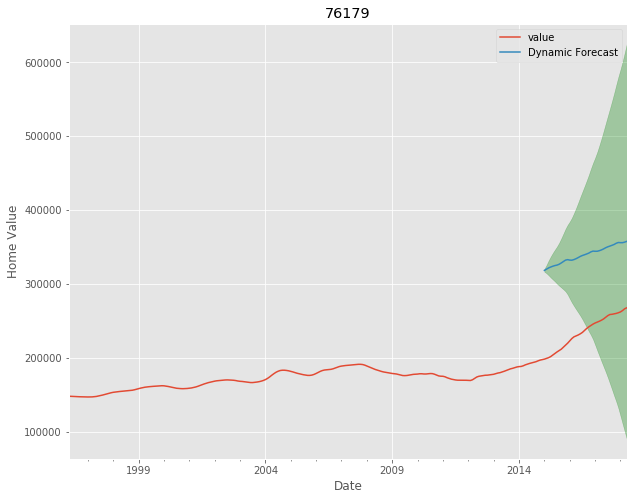

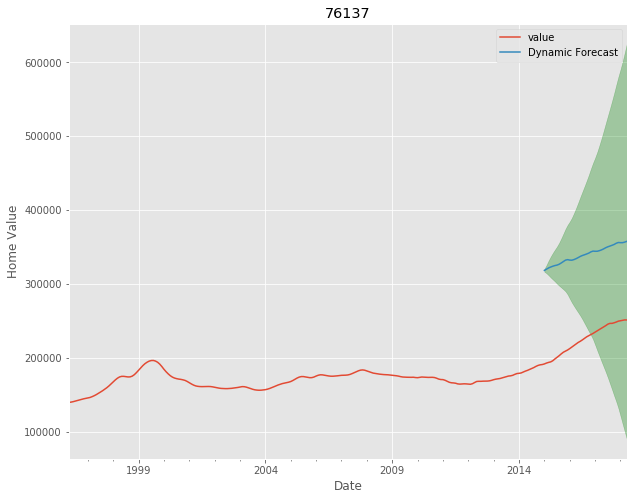

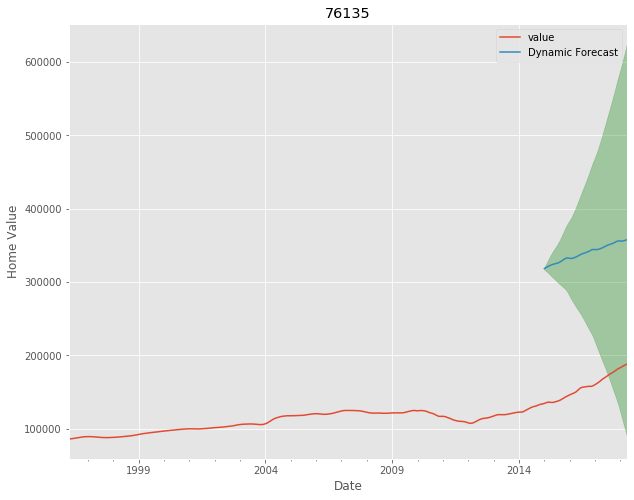

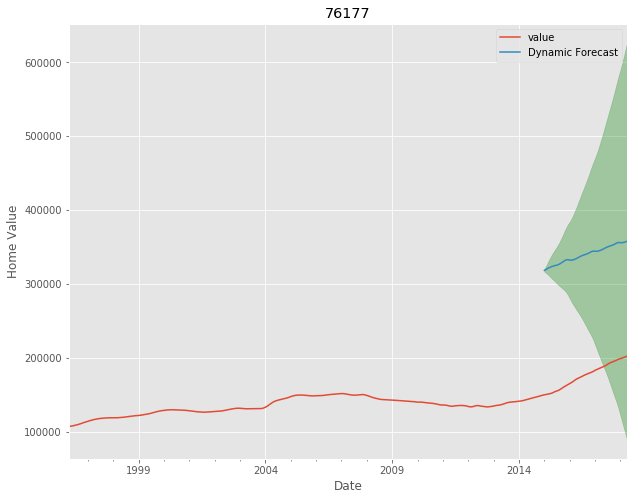

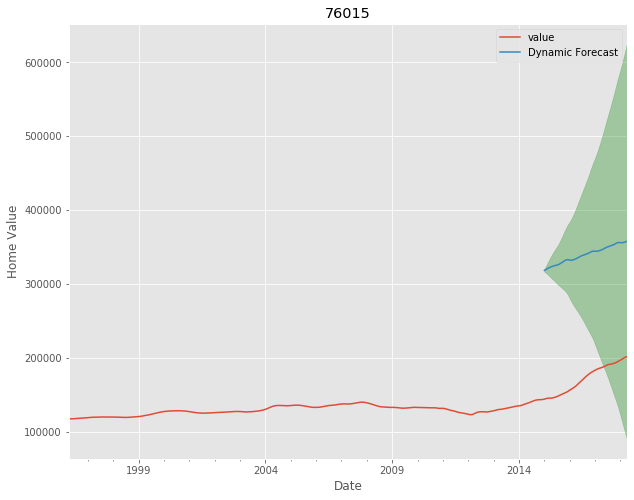

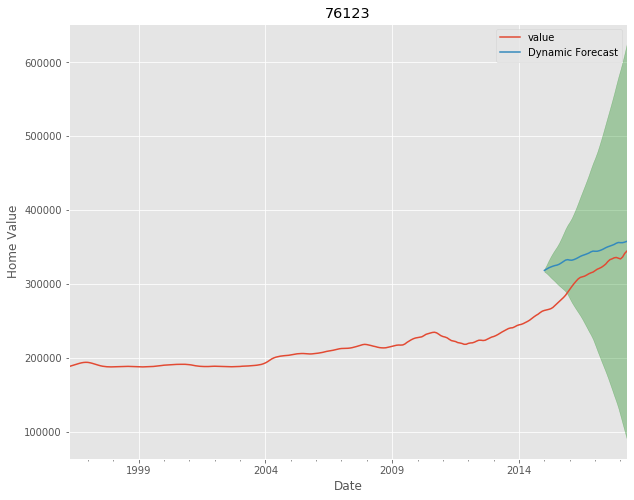

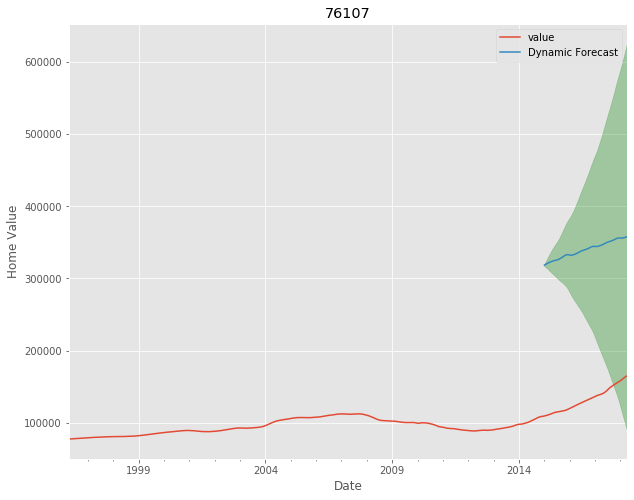

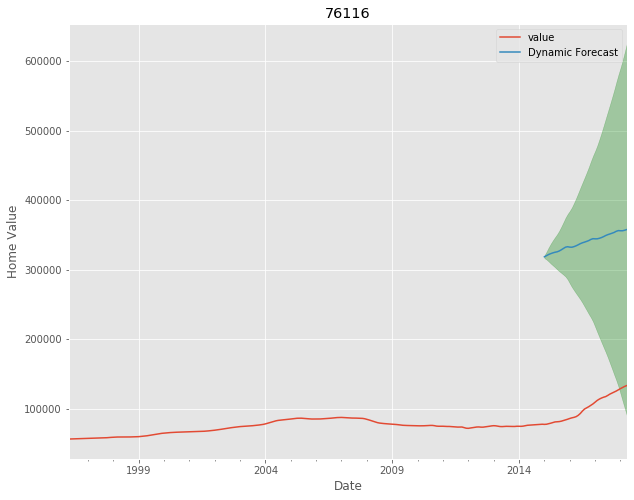

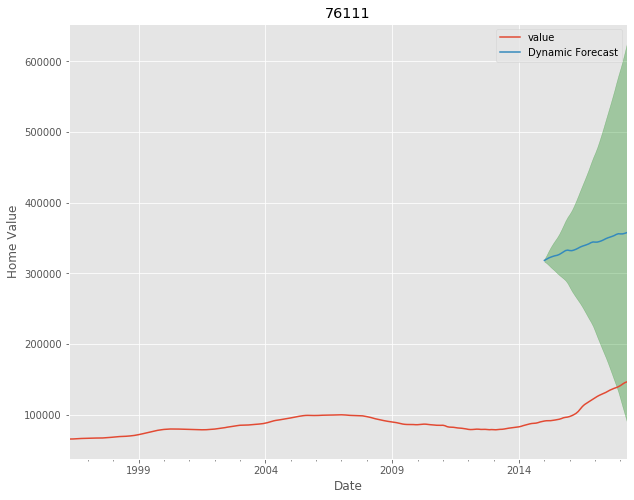

In [125]:
# Plot the dynamic forecast with confidence intervals.
for name, df in zip(top_10_mse_zip_list, zip_dfs):
    ax = df.plot(label='observed', figsize=(10, 8))
    zip_forecasted.plot(label='Dynamic Forecast', ax=ax)
    
    ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Home Value')

    plt.legend()
    plt.title(f"{name}")
    plt.show()


* From the above graphs, there clearly seems to be an issue with predicted home prices. Even though the trends seem to be somewhat accurate, the predicted values are much higher than they should be.


* Forecasting off of these highly inaccurate predictions will yield inaccurate future home prices. However, for the sake of completion 3 year forecasts will be made

In [118]:
#Final Model 
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
prediction = []
pred_conf = []

for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    
    current.append(df['2018-04']['value'][0])
    forecast_table['Zipcode'] = Zipcode
    forecast_3Yr.append(forecast_3)
    prediction.append(pred_3)
    pred_conf.append(pred_conf_3)
    
forecast_table['Current Value'] = current
forecast_table['3 Year Value'] = forecast_3Yr
forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

In [119]:
forecast_table.sort_values(by=['3Yr-ROI'], ascending=False)

,Zipcode,Current Value,3 Years Value,3Yr-ROI
37,76117,137000.0,345082.107690,1.518848
30,76107,439900.0,893324.540854,1.030745
48,76137,123700.0,199697.845640,0.614372
38,76118,208100.0,330819.328189,0.589713
56,76244,103600.0,163485.195164,0.578042
6,76012,164900.0,248664.897643,0.507974
13,76020,285500.0,427967.888639,0.499012
53,76179,216600.0,323346.508446,0.492828
42,76126,164400.0,244308.209263,0.486060
14,76021,95100.0,140440.709184,0.476769


* The above df shows the 3 year home value forecast for each zip code along with their respective ROI. However, these values are known to be highly inaccurate. This is seen in the above visualizations where price predictions began at much higher values than where the actual home prices were documented.

# Conclusion

* Having used the SARIMA model for time series analysis on home values in the Fort Worth area, it is clear from the results that further model refinement must be performed. There are a variety of steps that will refine the model to make more accurate predictions moving forward. They include:


  * Refine the initial investment strategy to decrease number of zip codes to analyze
  * Increase the hyper-parameter search criteria allowing for more stationary time series and subsequently more    accurate inputs for the SARMIA model
  * Split the time series to test/train a model after the 2008 recession. This could potentially more accurately capture the post recession trend while allowing for better home price forecasting.
    
    
* In the sake of limited time, these model refinements will have to come at a later date. But, will result in much more accurate predictions. After these modifications are performed, the top 5 zip codes to invest for 3 year ROI can be recommended; it doesn't seem prudent at this time to provide investment advice with the current home price forecasts.

## Recommendations

* Once the model provides more accurate predictions, there are plenty of other considerations to incorporate into a housing investment strategy. These include integrating more data such as school ratings, demopgraphics, income levels, rent/own ratio, job opportunities, and nearby amenities to name a few. All of these variables can provide a much more accurate housing price evaluation for potential future investments within the target areas. 